# Void Networks Analysis: JSON Schema Network Discovery and Analysis

This notebook recursively searches for JSON schemas in the notebooks/ directory, loads them into a NetworkX graph using their metadata, and performs comprehensive network analysis similar to the RDF config network analysis.

## Import Required Libraries

Import necessary libraries including os, json, networkx, matplotlib, pandas, and other analysis tools.

In [5]:
import os
import json
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from collections import defaultdict, Counter
from typing import Dict, List, Tuple, Any, Optional
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

KeyboardInterrupt: 

## Load schemas

In [ ]:
import os
import json
import networkx as nx
from pathlib import Path
from collections import defaultdict, Counter

# Recursively find and load all .json files in the notebooks directory
def load_all_json_files(directory_path):
    """
    Recursively search for .json files and load each into a dictionary
    """
    json_data = {}
    
    # Walk through all directories and files
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                relative_path = os.path.relpath(file_path, directory_path)
                
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                    json_data[relative_path] = data
                    print(f"Loaded: {relative_path}")
                    
                except json.JSONDecodeError as e:
                    print(f"JSON decode error in {relative_path}: {e}")
                    json_data[relative_path] = {"error": f"JSON decode error: {e}"}
                    
                except Exception as e:
                    print(f"Error loading {relative_path}: {e}")
                    json_data[relative_path] = {"error": f"Loading error: {e}"}
    
    return json_data

def is_schema_node(uri):
    """
    Check if a URI is a schema/ontology node that should be filtered out
    STRICT FILTERING: No RDF, OWL, or ontology nodes allowed
    """
    # Convert to string and lowercase for pattern matching
    uri_str = str(uri).lower()

    # Comprehensive schema/ontology patterns - NO RDF/OWL nodes allowed
    schema_patterns = [
        # RDF/RDFS patterns
        'rdfs#', 'rdf-syntax-ns#', '/rdf/', 'rdf#', 'rdfs/', 'rdf-schema',
        # OWL patterns  
        'owl#', '/owl/', 'owl/', 'owl.', 'owlapi',
        # W3C patterns
        'w3.org', 'w3c.', 'www.w3.org',
        # Dublin Core
        'dc/terms/', 'dublincore', 'dc/elements',
        # Schema.org and other vocabularies
        'schema.org', 'xmlns.com', 'purl.org',
        # FOAF
        'foaf/', 'xmlns.com/foaf',
        # Generic RDF/OWL terms
        'literal', 'resource', 'class', 'property', 'datatype',
        'objectproperty', 'datatypeproperty', 'annotationproperty',
        'ontology', 'imports', 'versioninfo', 'comment', 'label',
        # SKOS
        'skos', 'concept', 'conceptscheme',
        # VOID vocabulary
        'void#', 'void/', 'datadump', 'dataset',
        # Other common ontology patterns
        'protege', 'semanticweb', 'ontologydesignpattern'
    ]

    # Additional strict checks for RDF/OWL specific terms
    rdf_owl_terms = [
        'type', 'subclassof', 'subpropertyof', 'domain', 'range',
        'inverseof', 'equivalentclass', 'equivalentproperty',
        'differentfrom', 'sameas', 'disjointwith', 'unionof',
        'intersectionof', 'complementof', 'oneof', 'restriction',
        'cardinality', 'mincardinality', 'maxcardinality',
        'hasvalue', 'somevaluesfrom', 'allvaluesfrom'
    ]

    # Check schema patterns
    for pattern in schema_patterns:
        if pattern in uri_str:
            return True

    # Check if URI ends with common RDF/OWL terms
    uri_end = uri_str.split('#')[-1].split('/')[-1]
    if uri_end in rdf_owl_terms:
        return True

    return False


def load_all_json_files(directory_path):
    """
    Recursively search for .json files and load each into a dictionary
    """
    json_data = {}

    # Walk through all directories and files
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith(".json"):
                file_path = os.path.join(root, file)
                relative_path = os.path.relpath(file_path, directory_path)

                try:
                    with open(file_path, "r", encoding="utf-8") as f:
                        data = json.load(f)
                    json_data[relative_path] = data
                    print(f"Loaded: {relative_path}")

                except json.JSONDecodeError as e:
                    print(f"JSON decode error in {relative_path}: {e}")
                    json_data[relative_path] = {"error": f"JSON decode error: {e}"}

                except Exception as e:
                    print(f"Error loading {relative_path}: {e}")
                    json_data[relative_path] = {"error": f"Loading error: {e}"}

    return json_data


def create_schema_graph_from_triples(json_data):
    """
    Create a NetworkX graph from schema triples data
    Each [subject, predicate, object] triple becomes an edge between subject and object nodes
    Filter out schema/ontology nodes but keep predicates for analysis
    """
    G = nx.MultiDiGraph()  # Allow multiple edges between same nodes
    
    # Counters for metadata
    source_stats = defaultdict(lambda: {
        'subject_count': 0, 'object_count': 0, 'predicate_count': 0,
        'subjects': set(), 'objects': set(), 'predicates': set(),
        'triple_count': 0, 'filtered_triple_count': 0, 'complexity_score': 0
    })
    
    # Enhanced predicate analysis
    predicate_analysis = defaultdict(lambda: {
        'usage_count': 0,
        'unique_subjects': set(),
        'unique_objects': set(),
        'sources': set(),
        'subject_types': Counter(),
        'object_types': Counter()
    })
    
    total_triples = 0
    filtered_triples = 0
    
    # Process each JSON file containing triples
    for file_path, data in json_data.items():
        if isinstance(data, dict) and "error" not in data and "triples" in data:
            print(f"Processing triples from: {file_path}")
            
            triples = data.get("triples", [])
            
            # Track stats for this source
            stats = source_stats[file_path]
            stats['triple_count'] = len(triples)
            
            # Iterate through each [subject, predicate, object] triple
            for triple in triples:
                if len(triple) == 3:
                    subject, predicate, obj = triple
                    total_triples += 1
                    
                    # Filter out schema/ontology nodes but keep predicates for analysis
                    subject_is_schema = is_schema_node(subject)
                    object_is_schema = is_schema_node(obj)
                    
                    # Always analyze predicates regardless of filtering
                    pred_stats = predicate_analysis[predicate]
                    pred_stats['usage_count'] += 1
                    pred_stats['sources'].add(file_path)
                    pred_stats['unique_subjects'].add(subject)
                    pred_stats['unique_objects'].add(obj)
                    pred_stats['subject_types'][classify_uri(subject)] += 1
                    pred_stats['object_types'][classify_uri(obj)] += 1
                    
                    # Only add to graph if both subject and object are NOT schema nodes
                    if not subject_is_schema and not object_is_schema:
                        # Add subject node if not exists
                        if not G.has_node(subject):
                            G.add_node(subject, 
                                     node_type='domain_resource',
                                     sources=set(),
                                     uri_type=classify_uri(subject))
                        
                        # Add object node if not exists
                        if not G.has_node(obj):
                            G.add_node(obj,
                                     node_type='domain_resource', 
                                     sources=set(),
                                     uri_type=classify_uri(obj))
                        
                        # Add edge from subject to object with predicate as edge data
                        G.add_edge(subject, obj,
                                 predicate=predicate,
                                 source=file_path,
                                 predicate_type=classify_uri(predicate))
                        
                        # Update node sources
                        G.nodes[subject]['sources'].add(file_path)
                        G.nodes[obj]['sources'].add(file_path)
                        
                        stats['filtered_triple_count'] += 1
                    else:
                        filtered_triples += 1
                    
                    # Update statistics (track all subjects/objects/predicates)
                    stats['subjects'].add(subject)
                    stats['objects'].add(obj)
                    stats['predicates'].add(predicate)
            
            # Calculate complexity score
            stats['subject_count'] = len(stats['subjects'])
            stats['object_count'] = len(stats['objects'])
            stats['predicate_count'] = len(stats['predicates'])
            stats['complexity_score'] = (stats['subject_count'] + 
                                       stats['object_count'] + 
                                       stats['predicate_count'] * 2 +
                                       stats['triple_count'] * 0.1)
    
    # Update node degrees
    for node in G.nodes():
        G.nodes[node]['in_degree'] = G.in_degree(node)
        G.nodes[node]['out_degree'] = G.out_degree(node)
        G.nodes[node]['total_degree'] = G.degree(node)
    
    print(f"\nFiltering Results:")
    print(f"  Total triples processed: {total_triples}")
    print(f"  Schema/ontology triples filtered out: {filtered_triples}")
    print(f"  Domain-specific triples in graph: {G.number_of_edges()}")
    print(f"  Filtering ratio: {(filtered_triples/total_triples)*100:.1f}% filtered")
    
    return G, source_stats, predicate_analysis

def classify_uri(uri):
    """
    Classify URI type based on common patterns
    Enhanced to catch more RDF/OWL patterns
    """
    uri_str = str(uri).lower()
    
    # RDF patterns
    if any(pattern in uri_str for pattern in ['rdfs#', 'rdf-schema', '/rdf/', 'rdf#']):
        return 'RDFS'
    elif any(pattern in uri_str for pattern in ['rdf-syntax-ns#', 'rdf-syntax']):
        return 'RDF'
    # OWL patterns
    elif any(pattern in uri_str for pattern in ['owl#', '/owl/', 'owl/']):
        return 'OWL'
    # Dublin Core
    elif any(pattern in uri_str for pattern in ['dc/terms/', 'dublincore', 'dc/elements']):
        return 'Dublin Core'
    # FOAF
    elif any(pattern in uri_str for pattern in ['foaf/', 'xmlns.com/foaf']):
        return 'FOAF'
    # W3C
    elif any(pattern in uri_str for pattern in ['w3.org', 'w3c.']):
        return 'W3C'
    # PURL
    elif 'purl.org' in uri_str:
        return 'PURL'
    # Schema.org
    elif 'schema.org' in uri_str:
        return 'Schema.org'
    # SKOS
    elif any(pattern in uri_str for pattern in ['skos', 'concept']):
        return 'SKOS'
    # VOID
    elif any(pattern in uri_str for pattern in ['void#', 'void/', 'datadump']):
        return 'VOID'
    # PubChem (domain specific)
    elif 'pubchem' in uri_str:
        return 'PubChem'
    # Generic RDF types
    elif any(pattern in uri_str for pattern in ['literal', 'resource', 'class', 'property']):
        return 'RDF_Type'
    else:
        return 'Domain_Specific'

# Load all JSON files from the current notebooks directory
notebooks_dir = "."  # Current directory (notebooks)
all_json_data = load_all_json_files(notebooks_dir)

print(f"\nFound {len(all_json_data)} JSON files")

# Create graph from schema triples - filter out schema nodes, focus on domain data
G, source_stats, predicate_analysis = create_schema_graph_from_triples(all_json_data)

print(f"\nDomain-Specific Triple Graph Created:")
print(f"  Nodes (Domain URIs): {G.number_of_nodes()}")
print(f"  Edges (Domain triples): {G.number_of_edges()}")

# Display source statistics
print(f"\nSource File Statistics:")
print("=" * 50)
for source, stats in source_stats.items():
    print(f"\n{source}:")
    print(f"  Total triples: {stats['triple_count']}")
    print(f"  Domain triples in graph: {stats['filtered_triple_count']}")
    if stats['triple_count'] > 0:
        filtering_ratio = ((stats['triple_count'] - stats['filtered_triple_count'])/stats['triple_count'])*100
        print(f"  Filtering ratio: {filtering_ratio:.1f}% filtered")
    else:
        print(f"  Filtering ratio: N/A (no triples)")
    print(f"  Unique subjects: {stats['subject_count']}")
    print(f"  Unique objects: {stats['object_count']}")
    print(f"  Unique predicates: {stats['predicate_count']}")

# Display node type distribution (domain nodes only)
if G.number_of_nodes() > 0:
    node_types = Counter(G.nodes[node]['uri_type'] for node in G.nodes())
    print(f"\nDomain Node Type Distribution:")
    for node_type, count in node_types.most_common():
        print(f"  {node_type}: {count}")

    # Display top degree nodes
    print(f"\nTop 10 Most Connected Domain Nodes:")
    degree_sorted = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]
    for node, degree in degree_sorted:
        node_type = G.nodes[node]['uri_type']
        short_uri = node.split('/')[-1] if '/' in node else node.split('#')[-1] if '#' in node else node[-30:]
        print(f"  {short_uri} ({node_type}): {degree} connections")

    # Show sample domain triples
    print(f"\nSample Domain Triples in Graph:")
    print("=" * 50)
    sample_count = 0
    for u, v, key, edge_data in G.edges(keys=True, data=True):
        if sample_count < 5:
            predicate = edge_data['predicate']
            source = edge_data['source']
            u_short = u.split('/')[-1] if '/' in u else u.split('#')[-1] if '#' in u else u[-20:]
            v_short = v.split('/')[-1] if '/' in v else v.split('#')[-1] if '#' in v else v[-20:]
            pred_short = predicate.split('/')[-1] if '/' in predicate else predicate.split('#')[-1] if '#' in predicate else predicate[-20:]
            print(f"  [{u_short}] --{pred_short}--> [{v_short}] (from {source})")
            sample_count += 1
else:
    print("\nNo domain-specific triples found after filtering!")

# Enhanced Predicate Analysis
print(f"\n" + "=" * 70)
print(f"ENHANCED PREDICATE ANALYSIS")
print(f"=" * 70)

print(f"\nPredicate Overview:")
print(f"Total unique predicates found: {len(predicate_analysis)}")

# Top predicates by usage
print(f"\nTop 15 Most Used Predicates:")
print("-" * 60)
sorted_predicates = sorted(predicate_analysis.items(), key=lambda x: x[1]['usage_count'], reverse=True)
for i, (predicate, stats) in enumerate(sorted_predicates[:15], 1):
    pred_short = predicate.split('/')[-1] if '/' in predicate else predicate.split('#')[-1] if '#' in predicate else predicate[-30:]
    pred_type = classify_uri(predicate)
    print(f"{i:2d}. {pred_short} ({pred_type})")
    print(f"    Usage: {stats['usage_count']} times")
    print(f"    Connects {len(stats['unique_subjects'])} subjects to {len(stats['unique_objects'])} objects")
    print(f"    Sources: {len(stats['sources'])} files")
    print()

# Predicate type distribution
print(f"\nPredicate Type Distribution:")
print("-" * 40)
predicate_type_counts = Counter()
for predicate, stats in predicate_analysis.items():
    pred_type = classify_uri(predicate)
    predicate_type_counts[pred_type] += stats['usage_count']

for pred_type, count in predicate_type_counts.most_common():
    print(f"  {pred_type}: {count} uses")

# Predicate connectivity analysis
print(f"\nPredicate Connectivity Analysis:")
print("-" * 40)
connectivity_stats = []
for predicate, stats in predicate_analysis.items():
    connectivity_stats.append({
        'predicate': predicate,
        'usage_count': stats['usage_count'],
        'subject_diversity': len(stats['unique_subjects']),
        'object_diversity': len(stats['unique_objects']),
        'source_diversity': len(stats['sources']),
        'connectivity_ratio': len(stats['unique_subjects']) * len(stats['unique_objects']) / max(stats['usage_count'], 1)
    })

# Sort by connectivity ratio (measures how well a predicate connects different entities)
connectivity_stats.sort(key=lambda x: x['connectivity_ratio'], reverse=True)

print(f"Top 10 Predicates by Connectivity (subject-object diversity):")
for i, pred_stats in enumerate(connectivity_stats[:10], 1):
    pred_short = pred_stats['predicate'].split('/')[-1] if '/' in pred_stats['predicate'] else pred_stats['predicate'].split('#')[-1] if '#' in pred_stats['predicate'] else pred_stats['predicate'][-30:]
    print(f"{i:2d}. {pred_short}")
    print(f"    Connectivity ratio: {pred_stats['connectivity_ratio']:.2f}")
    print(f"    {pred_stats['subject_diversity']} subjects × {pred_stats['object_diversity']} objects = {pred_stats['usage_count']} triples")
    print()

Loaded: idsm/pubchem_organization_schema.json
Loaded: idsm/pubchem_author_schema.json
Loaded: idsm/pubchem_source_schema.json
Loaded: idsm/pubchem_descriptor_substance_schema.json
Loaded: idsm/chebi_schema.json
Loaded: idsm/pubchem_reference_schema.json
Loaded: idsm/pubchem_measuregroup_schema.json
Loaded: idsm/pubchem_concept_schema.json
Loaded: idsm/pubchem_grant_schema.json
Loaded: idsm/pubchem_cooccurrence_schema.json
Loaded: idsm/drugbank_drugs_schema.json
Loaded: idsm/pubchem_book_schema.json
Loaded: idsm/pubchem_taxonomy_schema.json
Loaded: idsm/pubchem_cell_schema.json
Loaded: idsm/pubchem_journal_schema.json
Loaded: idsm/pubchem_disease_schema.json
Loaded: idsm/pubchem_inchikey_schema.json
Loaded: pubchem/MeSH_schema_fast.json
Loaded: aopwikirdf/aopwikirdf_complete_schema.json
Loaded: wikipathways/wikipathways_complete_schema.json
Loaded: wikipathways/wikipathways_schema.json
Loaded: wikipathways/wikipathways_fast_schema.json
Loaded: wikipathways/wikipathways_schema_fast.json


## Create NetworkX Graph from Schema Data

Build a NetworkX graph where nodes represent schemas and edges represent relationships or dependencies between schemas.

## Advanced Predicate Analysis

Deep analysis of predicates as the key connectors in the RDF network. Predicates are the relationships that define the semantic structure.

In [ ]:
def analyze_predicate_patterns(predicate_analysis, G):
    """
    Advanced analysis of predicate usage patterns and network roles
    """
    print("Advanced Predicate Pattern Analysis:")
    print("=" * 50)
    
    # Create predicate DataFrames for analysis
    predicate_data = []
    
    for predicate, stats in predicate_analysis.items():
        pred_short = predicate.split('/')[-1] if '/' in predicate else predicate.split('#')[-1] if '#' in predicate else predicate[-30:]
        pred_type = classify_uri(predicate)
        
        # Calculate various metrics
        subject_diversity = len(stats['unique_subjects'])
        object_diversity = len(stats['unique_objects'])
        usage_count = stats['usage_count']
        source_diversity = len(stats['sources'])
        
        # Connectivity metrics
        connectivity_ratio = (subject_diversity * object_diversity) / max(usage_count, 1)
        hub_score = subject_diversity / max(usage_count, 1)  # How many different subjects per use
        authority_score = object_diversity / max(usage_count, 1)  # How many different objects per use
        
        predicate_data.append({
            'predicate': predicate,
            'short_name': pred_short,
            'type': pred_type,
            'usage_count': usage_count,
            'subject_diversity': subject_diversity,
            'object_diversity': object_diversity,
            'source_diversity': source_diversity,
            'connectivity_ratio': connectivity_ratio,
            'hub_score': hub_score,
            'authority_score': authority_score,
            'avg_uses_per_source': usage_count / max(source_diversity, 1)
        })
    
    predicate_df = pd.DataFrame(predicate_data)
    
    print(f"\nPredicate Statistics Summary:")
    print(predicate_df[['usage_count', 'subject_diversity', 'object_diversity', 'connectivity_ratio']].describe())
    
    # Predicate role classification
    print(f"\nPredicate Role Classification:")
    print("-" * 40)
    
    # High connectivity predicates (connect many different entities)
    high_connectivity = predicate_df[predicate_df['connectivity_ratio'] > predicate_df['connectivity_ratio'].quantile(0.8)]
    print(f"High Connectivity Predicates ({len(high_connectivity)}):")
    for idx, row in high_connectivity.nlargest(5, 'connectivity_ratio').iterrows():
        print(f"  {row['short_name']} ({row['type']}): connects {row['subject_diversity']}×{row['object_diversity']} entities")
    
    # Hub predicates (many subjects, few objects per use)
    hub_predicates = predicate_df[predicate_df['hub_score'] > predicate_df['hub_score'].quantile(0.8)]
    print(f"\nHub Predicates ({len(hub_predicates)}):")
    for idx, row in hub_predicates.nlargest(5, 'hub_score').iterrows():
        print(f"  {row['short_name']} ({row['type']}): {row['subject_diversity']} subjects, hub score {row['hub_score']:.3f}")
    
    # Authority predicates (many objects, few subjects per use)
    auth_predicates = predicate_df[predicate_df['authority_score'] > predicate_df['authority_score'].quantile(0.8)]
    print(f"\nAuthority Predicates ({len(auth_predicates)}):")
    for idx, row in auth_predicates.nlargest(5, 'authority_score').iterrows():
        print(f"  {row['short_name']} ({row['type']}): {row['object_diversity']} objects, authority score {row['authority_score']:.3f}")
    
    # Most frequent predicates
    frequent_predicates = predicate_df.nlargest(10, 'usage_count')
    print(f"\nMost Frequent Predicates:")
    for idx, row in frequent_predicates.iterrows():
        print(f"  {row['short_name']} ({row['type']}): {row['usage_count']} uses")
    
    return predicate_df

def visualize_predicate_analysis(predicate_df, predicate_analysis):
    """
    Create comprehensive visualizations for predicate analysis
    """
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle('Comprehensive Predicate Analysis: The Semantic Connectors', fontsize=16, fontweight='bold')
    
    # 1. Predicate usage distribution
    axes[0, 0].hist(predicate_df['usage_count'], bins=50, alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Predicate Usage Distribution')
    axes[0, 0].set_xlabel('Usage Count')
    axes[0, 0].set_ylabel('Number of Predicates')
    axes[0, 0].set_yscale('log')
    
    # 2. Predicate type distribution
    type_counts = predicate_df['type'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(type_counts)))
    axes[0, 1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', colors=colors)
    axes[0, 1].set_title('Predicate Type Distribution')
    
    # 3. Connectivity analysis scatter plot
    scatter = axes[1, 0].scatter(predicate_df['subject_diversity'], predicate_df['object_diversity'], 
                                c=predicate_df['usage_count'], s=60, alpha=0.7, cmap='viridis')
    axes[1, 0].set_title('Predicate Connectivity Pattern')
    axes[1, 0].set_xlabel('Subject Diversity')
    axes[1, 0].set_ylabel('Object Diversity')
    plt.colorbar(scatter, ax=axes[1, 0], label='Usage Count')
    
    # 4. Hub vs Authority scores
    axes[1, 1].scatter(predicate_df['hub_score'], predicate_df['authority_score'], 
                      c=predicate_df['usage_count'], s=60, alpha=0.7, cmap='plasma')
    axes[1, 1].set_title('Hub vs Authority Scores')
    axes[1, 1].set_xlabel('Hub Score (Subject Diversity)')
    axes[1, 1].set_ylabel('Authority Score (Object Diversity)')
    
    # 5. Top predicates by usage (bar chart)
    top_predicates = predicate_df.nlargest(15, 'usage_count')
    bars = axes[2, 0].bar(range(len(top_predicates)), top_predicates['usage_count'], alpha=0.8)
    axes[2, 0].set_title('Top 15 Predicates by Usage')
    axes[2, 0].set_xlabel('Predicates')
    axes[2, 0].set_ylabel('Usage Count')
    axes[2, 0].set_xticks(range(len(top_predicates)))
    axes[2, 0].set_xticklabels(top_predicates['short_name'], rotation=45, ha='right')
    
    # Color bars by type
    type_colors = {ptype: colors[i] for i, ptype in enumerate(type_counts.index)}
    for bar, ptype in zip(bars, top_predicates['type']):
        bar.set_color(type_colors.get(ptype, 'gray'))
    
    # 6. Source diversity vs usage
    axes[2, 1].scatter(predicate_df['source_diversity'], predicate_df['usage_count'], 
                      alpha=0.7, color='coral', s=60)
    axes[2, 1].set_title('Source Diversity vs Usage')
    axes[2, 1].set_xlabel('Number of Source Files')
    axes[2, 1].set_ylabel('Usage Count')
    
    plt.tight_layout()
    plt.show()
    
    # Create predicate network visualization
    print(f"\nCreating Predicate Co-occurrence Network...")
    create_predicate_network(predicate_analysis)

def create_predicate_network(predicate_analysis):
    """
    Create a network showing how predicates co-occur in the same sources
    """
    # Build predicate co-occurrence matrix
    predicate_sources = {}
    for predicate, stats in predicate_analysis.items():
        predicate_sources[predicate] = stats['sources']
    
    # Create predicate network
    pred_network = nx.Graph()
    predicates = list(predicate_sources.keys())
    
    # Add nodes
    for predicate in predicates:
        pred_short = predicate.split('/')[-1] if '/' in predicate else predicate.split('#')[-1] if '#' in predicate else predicate[-20:]
        pred_network.add_node(predicate, 
                            short_name=pred_short,
                            type=classify_uri(predicate),
                            usage_count=predicate_analysis[predicate]['usage_count'],
                            source_count=len(predicate_analysis[predicate]['sources']))
    
    # Add edges for predicates that co-occur in sources
    for i, pred1 in enumerate(predicates):
        for j, pred2 in enumerate(predicates[i+1:], i+1):
            shared_sources = predicate_sources[pred1] & predicate_sources[pred2]
            if len(shared_sources) > 0:
                pred_network.add_edge(pred1, pred2, 
                                    shared_sources=len(shared_sources),
                                    sources=list(shared_sources))
    
    # Visualize if not too large
    if pred_network.number_of_nodes() <= 50:
        plt.figure(figsize=(14, 10))
        
        # Position nodes
        pos = nx.spring_layout(pred_network, k=3, iterations=50)
        
        # Node colors by type
        node_types = [pred_network.nodes[node]['type'] for node in pred_network.nodes()]
        unique_types = list(set(node_types))
        type_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_types)))
        type_color_map = {ptype: type_colors[i] for i, ptype in enumerate(unique_types)}
        node_colors = [type_color_map[ptype] for ptype in node_types]
        
        # Node sizes by usage count
        node_sizes = [pred_network.nodes[node]['usage_count'] * 10 + 100 for node in pred_network.nodes()]
        
        # Edge widths by shared sources
        edge_widths = [pred_network[u][v]['shared_sources'] for u, v in pred_network.edges()]
        max_width = max(edge_widths) if edge_widths else 1
        edge_widths = [w * 5 / max_width for w in edge_widths]
        
        # Draw network
        nx.draw_networkx_nodes(pred_network, pos, 
                              node_color=node_colors,
                              node_size=node_sizes,
                              alpha=0.8)
        
        nx.draw_networkx_edges(pred_network, pos, 
                              width=edge_widths,
                              alpha=0.6,
                              edge_color='gray')
        
        # Labels for high-usage predicates
        high_usage_nodes = [node for node in pred_network.nodes() 
                           if pred_network.nodes[node]['usage_count'] >= np.percentile([pred_network.nodes[n]['usage_count'] for n in pred_network.nodes()], 70)]
        
        labels = {node: pred_network.nodes[node]['short_name'] for node in high_usage_nodes}
        nx.draw_networkx_labels(pred_network, pos, labels, font_size=8, font_weight='bold')
        
        plt.title('Predicate Co-occurrence Network\n(Predicates connected if they appear in same sources)', 
                  fontsize=14, fontweight='bold')
        plt.axis('off')
        
        # Legend
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                     markerfacecolor=type_color_map[ptype], 
                                     markersize=10, label=ptype)
                          for ptype in unique_types]
        plt.legend(handles=legend_elements, loc='upper right')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Predicate co-occurrence network: {pred_network.number_of_nodes()} predicates, {pred_network.number_of_edges()} co-occurrences")
    else:
        print(f"Too many predicates ({pred_network.number_of_nodes()}) for co-occurrence visualization")

# Run advanced predicate analysis
predicate_df = analyze_predicate_patterns(predicate_analysis, G)

# Create comprehensive predicate visualizations
visualize_predicate_analysis(predicate_df, predicate_analysis)

In [ ]:
def get_node_metadata(G, node):
    """
    Extract comprehensive metadata for a graph node (domain-specific nodes only)
    """
    node_data = G.nodes[node]
    
    # Get all predicates this node participates in
    incoming_predicates = set()
    outgoing_predicates = set()
    
    for pred_node, _, edge_data in G.in_edges(node, data=True):
        incoming_predicates.add(edge_data['predicate'])
    
    for _, succ_node, edge_data in G.out_edges(node, data=True):
        outgoing_predicates.add(edge_data['predicate'])
    
    return {
        'uri': node,
        'uri_type': node_data['uri_type'],
        'total_degree': node_data['total_degree'],
        'in_degree': node_data['in_degree'],
        'out_degree': node_data['out_degree'],
        'sources': list(node_data['sources']),
        'source_count': len(node_data['sources']),
        'incoming_predicates': list(incoming_predicates),
        'outgoing_predicates': list(outgoing_predicates),
        'predicate_diversity': len(incoming_predicates) + len(outgoing_predicates)
    }

def analyze_graph_structure(G):
    """
    Analyze the structure of the domain-specific triple graph
    """
    print("Domain-Specific Graph Structure Analysis:")
    print("=" * 50)
    
    # Basic metrics
    print(f"Domain nodes: {G.number_of_nodes()}")
    print(f"Domain triples: {G.number_of_edges()}")
    print(f"Density: {nx.density(G):.6f}")
    
    # Convert to simple directed graph for analysis
    simple_G = nx.DiGraph(G)
    
    # Connectivity
    print(f"Strongly connected: {nx.is_strongly_connected(simple_G)}")
    print(f"Weakly connected: {nx.is_weakly_connected(simple_G)}")
    print(f"Strong components: {nx.number_strongly_connected_components(simple_G)}")
    print(f"Weak components: {nx.number_weakly_connected_components(simple_G)}")
    
    if G.number_of_nodes() > 0:
        # Degree statistics
        degrees = [d for n, d in G.degree()]
        print(f"Average degree: {np.mean(degrees):.2f}")
        print(f"Max degree: {max(degrees)}")
        print(f"Degree standard deviation: {np.std(degrees):.2f}")
    
    return simple_G

# Analyze the domain-specific graph structure
if G.number_of_nodes() > 0:
    simple_G = analyze_graph_structure(G)

    # Get detailed node metadata for domain nodes
    print(f"\nTop 15 Most Connected Domain Nodes with Metadata:")
    print("=" * 70)

    degree_sorted = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:15]
    node_metadata = []

    for node, degree in degree_sorted:
        metadata = get_node_metadata(G, node)
        node_metadata.append(metadata)
        
        # Shorten URI for display
        uri_short = node.split('/')[-1] if '/' in node else node.split('#')[-1] if '#' in node else node[-40:]
        
        print(f"\n{uri_short}")
        print(f"  Type: {metadata['uri_type']}")
        print(f"  Total degree: {metadata['total_degree']} (in: {metadata['in_degree']}, out: {metadata['out_degree']})")
        print(f"  Sources: {metadata['source_count']} ({', '.join(metadata['sources'][:2])}{'...' if len(metadata['sources']) > 2 else ''})")
        print(f"  Predicate diversity: {metadata['predicate_diversity']}")
        
        # Show some predicates
        if metadata['incoming_predicates']:
            in_preds = [p.split('/')[-1] if '/' in p else p.split('#')[-1] if '#' in p else p[-15:] for p in metadata['incoming_predicates'][:3]]
            print(f"  Incoming predicates: {', '.join(in_preds)}{'...' if len(metadata['incoming_predicates']) > 3 else ''}")
        
        if metadata['outgoing_predicates']:
            out_preds = [p.split('/')[-1] if '/' in p else p.split('#')[-1] if '#' in p else p[-15:] for p in metadata['outgoing_predicates'][:3]]
            print(f"  Outgoing predicates: {', '.join(out_preds)}{'...' if len(metadata['outgoing_predicates']) > 3 else ''}")

    # Create a DataFrame for easier analysis
    if node_metadata:
        metadata_df = pd.DataFrame(node_metadata)
        print(f"\nDomain Node Metadata Summary:")
        print(metadata_df[['uri_type', 'total_degree', 'source_count', 'predicate_diversity']].describe())

    # Analyze predicate usage patterns in the graph
    print(f"\nDomain Graph Predicate Usage:")
    print("=" * 50)

    graph_predicate_usage = Counter()
    for _, _, edge_data in G.edges(data=True):
        graph_predicate_usage[edge_data['predicate']] += 1

    print(f"Top 15 Predicates in Domain Graph:")
    for i, (predicate, count) in enumerate(graph_predicate_usage.most_common(15), 1):
        pred_short = predicate.split('/')[-1] if '/' in predicate else predicate.split('#')[-1] if '#' in predicate else predicate[-30:]
        pred_type = classify_uri(predicate)
        print(f"{i:2d}. {pred_short} ({pred_type}): {count} uses in domain graph")

    # Source participation analysis for domain nodes
    print(f"\nDomain Node Source Participation:")
    print("=" * 50)

    for source, stats in source_stats.items():
        if stats['filtered_triple_count'] > 0:
            print(f"\n{source}:")
            
            # Find domain nodes that appear only in this source
            domain_subjects = set()
            domain_objects = set()
            
            # Get domain-specific subjects and objects from this source
            for node in G.nodes():
                if source in G.nodes[node]['sources']:
                    # Check if this node appears as subject or object in this source
                    for u, v, edge_data in G.edges(data=True):
                        if edge_data['source'] == source:
                            if u == node:
                                domain_subjects.add(node)
                            if v == node:
                                domain_objects.add(node)
            
            exclusive_domain_subjects = domain_subjects.copy()
            exclusive_domain_objects = domain_objects.copy()
            
            # Remove nodes that appear in other sources
            for other_source, other_stats in source_stats.items():
                if other_source != source:
                    for node in list(exclusive_domain_subjects):
                        if other_source in G.nodes.get(node, {}).get('sources', set()):
                            exclusive_domain_subjects.discard(node)
                    for node in list(exclusive_domain_objects):
                        if other_source in G.nodes.get(node, {}).get('sources', set()):
                            exclusive_domain_objects.discard(node)
            
            print(f"  Domain nodes in graph: {len(domain_subjects | domain_objects)}")
            print(f"  Exclusive domain subjects: {len(exclusive_domain_subjects)}")
            print(f"  Exclusive domain objects: {len(exclusive_domain_objects)}")
            print(f"  Shared domain nodes: {len((domain_subjects | domain_objects) - (exclusive_domain_subjects | exclusive_domain_objects))}")

else:
    print("\nNo domain-specific nodes found after filtering!")
    print("All nodes were classified as schema/ontology nodes and filtered out.")
    print("This might indicate:")
    print("1. The dataset contains only schema definitions")
    print("2. The filtering criteria are too strict")
    print("3. The data uses different URI patterns than expected")

Graph Structure Analysis:
Nodes: 105
Edges: 5485
Density: 0.502289
Strongly connected: False
Weakly connected: True
Strong components: 65
Weak components: 1
Average degree: 104.48
Max degree: 1122
Degree standard deviation: 197.67

Top 15 Most Connected Nodes with Metadata:

http://www.w3.org/2000/01/rdf-schema#Literal
  Type: W3C
  Total degree: 1122 (in: 1122, out: 0)
  Sources: 22 (idsm/pubchem_cooccurrence_schema.json, idsm/pubchem_grant_schema.json, idsm/pubchem_reference_schema.json...)
  Predicate diversity: 154

http://www.w3.org/2000/01/rdf-schema#Resource
  Type: W3C
  Total degree: 919 (in: 919, out: 0)
  Sources: 22 (idsm/pubchem_cooccurrence_schema.json, idsm/pubchem_grant_schema.json, idsm/pubchem_reference_schema.json...)
  Predicate diversity: 66

http://vocabularies.wikipathways.org/wp#DataNode
  Type: Other
  Total degree: 836 (in: 436, out: 400)
  Sources: 4 (wikipathways/wikipathways_fast_schema.json, wikipathways/wikipathways_schema.json, wikipathways/wikipathways_

## Basic Graph Analysis

Perform initial graph analysis including node count, edge count, density, and basic structural properties.

In [ ]:
def analyze_basic_properties(G: nx.DiGraph) -> Dict:
    """
    Analyze basic graph properties.
    """
    analysis = {}
    
    # Basic counts
    analysis['node_count'] = G.number_of_nodes()
    analysis['edge_count'] = G.number_of_edges()
    analysis['self_loops'] = nx.number_of_selfloops(G)
    
    # Density and connectivity
    analysis['density'] = nx.density(G)
    analysis['is_strongly_connected'] = nx.is_strongly_connected(G)
    analysis['is_weakly_connected'] = nx.is_weakly_connected(G)
    analysis['number_strongly_connected_components'] = nx.number_strongly_connected_components(G)
    analysis['number_weakly_connected_components'] = nx.number_weakly_connected_components(G)
    
    # Convert to undirected for additional metrics
    G_undirected = G.to_undirected()
    analysis['is_connected'] = nx.is_connected(G_undirected)
    
    if analysis['is_connected']:
        analysis['diameter'] = nx.diameter(G_undirected)
        analysis['radius'] = nx.radius(G_undirected)
        analysis['average_shortest_path_length'] = nx.average_shortest_path_length(G_undirected)
    else:
        analysis['diameter'] = 'N/A (disconnected)'
        analysis['radius'] = 'N/A (disconnected)'
        analysis['average_shortest_path_length'] = 'N/A (disconnected)'
    
    # Degree statistics
    degrees = dict(G.degree())
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())
    
    analysis['average_degree'] = np.mean(list(degrees.values()))
    analysis['average_in_degree'] = np.mean(list(in_degrees.values()))
    analysis['average_out_degree'] = np.mean(list(out_degrees.values()))
    
    return analysis

# Perform basic analysis
basic_analysis = analyze_basic_properties(G)

print("Basic Graph Analysis Results:")
print("=" * 40)
for key, value in basic_analysis.items():
    print(f"{key.replace('_', ' ').title()}: {value}")

# Create a summary DataFrame
basic_metrics_df = pd.DataFrame([basic_analysis]).T
basic_metrics_df.columns = ['Value']
print(f"\nBasic Metrics Summary:")
print(basic_metrics_df)

Basic Graph Analysis Results:
Node Count: 105
Edge Count: 5485
Self Loops: 332
Density: 0.5022893772893773
Is Strongly Connected: False
Is Weakly Connected: True
Number Strongly Connected Components: 65
Number Weakly Connected Components: 1
Is Connected: True
Diameter: 2
Radius: 2
Average Shortest Path Length: 1.9075091575091576
Average Degree: 104.47619047619048
Average In Degree: 52.23809523809524
Average Out Degree: 52.23809523809524

Basic Metrics Summary:
                                          Value
node_count                                  105
edge_count                                 5485
self_loops                                  332
density                                0.502289
is_strongly_connected                     False
is_weakly_connected                        True
number_strongly_connected_components         65
number_weakly_connected_components            1
is_connected                               True
diameter                                      2
radius 

## Node and Edge Statistics

Calculate and visualize statistics about nodes and edges, including degree distribution and connectivity patterns.

Node Degree Statistics:
                                                  uri  \
4        http://www.w3.org/2000/01/rdf-schema#Literal   
1       http://www.w3.org/2000/01/rdf-schema#Resource   
98   http://vocabularies.wikipathways.org/wp#DataNode   
99  http://vocabularies.wikipathways.org/wp#GenePr...   
95    http://vocabularies.wikipathways.org/wp#Protein   
..                                                ...   
2   http://rdf.ncbi.nlm.nih.gov/pubchem/vocabulary...   
20                  http://purl.org/cerif/frapo/Grant   
9   http://rdf.ncbi.nlm.nih.gov/pubchem/vocabulary...   
21  http://rdf.ncbi.nlm.nih.gov/pubchem/vocabulary...   
8          http://purl.obolibrary.org/obo/IAO_0000129   

                 short_name  total_degree  in_degree  out_degree uri_type  \
4        rdf-schema#Literal          1122       1122           0      W3C   
1       rdf-schema#Resource           919        919           0      W3C   
98              wp#DataNode           836        436        

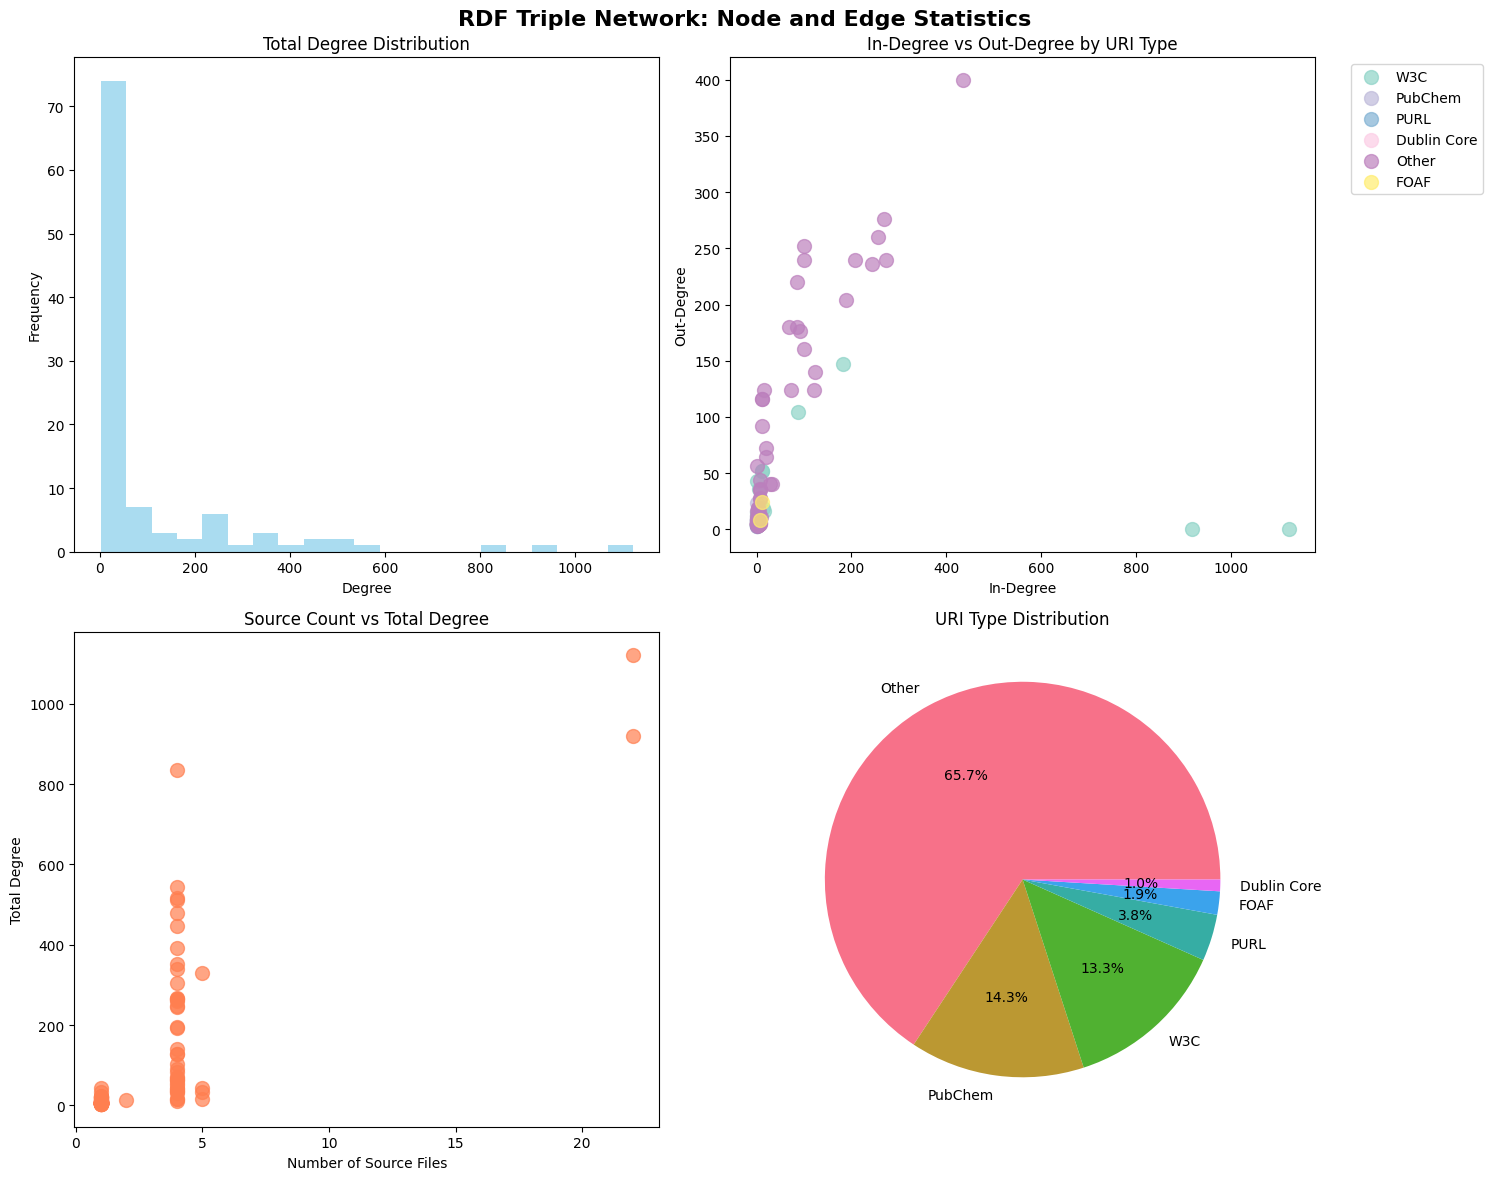


Predicate Type Distribution:
  Other: 3325
  Dublin Core: 1037
  PURL: 421
  W3C: 367
  RDF: 268
  FOAF: 66
  PubChem: 1

Top 15 Most Connected Nodes:
  rdf-schema#Literal (W3C)
    Total degree: 1122 (in: 1122, out: 0)
    Source files: 22
    Full URI: http://www.w3.org/2000/01/rdf-schema#Literal

  rdf-schema#Resource (W3C)
    Total degree: 919 (in: 919, out: 0)
    Source files: 22
    Full URI: http://www.w3.org/2000/01/rdf-schema#Resource

  wp#DataNode (Other)
    Total degree: 836 (in: 436, out: 400)
    Source files: 4
    Full URI: http://vocabularies.wikipathways.org/wp#DataNode

  wp#GeneProduct (Other)
    Total degree: 544 (in: 268, out: 276)
    Source files: 4
    Full URI: http://vocabularies.wikipathways.org/wp#GeneProduct

  wp#Protein (Other)
    Total degree: 516 (in: 256, out: 260)
    Source files: 4
    Full URI: http://vocabularies.wikipathways.org/wp#Protein

  wp#Metabolite (Other)
    Total degree: 512 (in: 272, out: 240)
    Source files: 4
    Full URI: 

In [ ]:
# Calculate degree statistics
degrees = dict(G.degree())
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Create degree DataFrames with actual node attributes from triple graph
degree_data = []
for node in G.nodes():
    node_attrs = G.nodes[node]
    
    # Extract meaningful URI parts for display
    if '/' in node:
        short_name = node.split('/')[-1]
    elif '#' in node:
        short_name = node.split('#')[-1]
    else:
        short_name = node[-30:]  # Last 30 characters
    
    degree_data.append({
        'uri': node,
        'short_name': short_name,
        'total_degree': degrees[node],
        'in_degree': in_degrees[node],
        'out_degree': out_degrees[node],
        'uri_type': node_attrs['uri_type'],
        'source_count': len(node_attrs['sources']),
        'node_type': node_attrs['node_type']
    })

degree_df = pd.DataFrame(degree_data)

# Display degree statistics
print("Node Degree Statistics:")
print("=" * 40)
print(degree_df.sort_values('total_degree', ascending=False))

print(f"\nDegree Distribution Summary:")
print(f"Average total degree: {degree_df['total_degree'].mean():.2f}")
print(f"Average in-degree: {degree_df['in_degree'].mean():.2f}")
print(f"Average out-degree: {degree_df['out_degree'].mean():.2f}")
print(f"Max total degree: {degree_df['total_degree'].max()}")
print(f"Min total degree: {degree_df['total_degree'].min()}")

# URI type statistics
print(f"\nURI Type Statistics:")
uri_type_stats = degree_df.groupby('uri_type').agg({
    'total_degree': ['mean', 'max', 'count'],
    'source_count': 'mean'
}).round(2)
print(uri_type_stats)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('RDF Triple Network: Node and Edge Statistics', fontsize=16, fontweight='bold')

# Degree distribution
axes[0, 0].hist(degree_df['total_degree'], bins=max(1, len(degree_df)//5), alpha=0.7, color='skyblue')
axes[0, 0].set_title('Total Degree Distribution')
axes[0, 0].set_xlabel('Degree')
axes[0, 0].set_ylabel('Frequency')

# In-degree vs Out-degree scatter colored by URI type
uri_types = degree_df['uri_type'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(uri_types)))
color_map = {uri_type: colors[i] for i, uri_type in enumerate(uri_types)}

for uri_type in uri_types:
    subset = degree_df[degree_df['uri_type'] == uri_type]
    axes[0, 1].scatter(subset['in_degree'], subset['out_degree'], 
                      c=[color_map[uri_type]], label=uri_type, s=100, alpha=0.7)

axes[0, 1].set_title('In-Degree vs Out-Degree by URI Type')
axes[0, 1].set_xlabel('In-Degree')
axes[0, 1].set_ylabel('Out-Degree')
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Source count vs degree relationship
axes[1, 0].scatter(degree_df['source_count'], degree_df['total_degree'], 
                   alpha=0.7, color='coral', s=100)
axes[1, 0].set_title('Source Count vs Total Degree')
axes[1, 0].set_xlabel('Number of Source Files')
axes[1, 0].set_ylabel('Total Degree')

# URI type distribution pie chart
uri_type_counts = degree_df['uri_type'].value_counts()
axes[1, 1].pie(uri_type_counts.values, labels=uri_type_counts.index, autopct='%1.1f%%')
axes[1, 1].set_title('URI Type Distribution')

plt.tight_layout()
plt.show()

# Predicate type analysis (corrected for MultiDiGraph)
predicate_types = Counter()
for u, v, key, edge_data in G.edges(keys=True, data=True):
    predicate_types[edge_data['predicate_type']] += 1

print(f"\nPredicate Type Distribution:")
for pred_type, count in predicate_types.most_common():
    print(f"  {pred_type}: {count}")

# Top nodes by degree with details
print(f"\nTop 15 Most Connected Nodes:")
print("=" * 60)
top_nodes = degree_df.nlargest(15, 'total_degree')
for idx, row in top_nodes.iterrows():
    print(f"  {row['short_name']} ({row['uri_type']})")
    print(f"    Total degree: {row['total_degree']} (in: {row['in_degree']}, out: {row['out_degree']})")
    print(f"    Source files: {row['source_count']}")
    print(f"    Full URI: {row['uri']}")
    print()

## Graph Visualization

Create various visualizations of the schema network using different layout algorithms and styling options.

Creating Triple Network Visualizations...

--- Spring Layout ---
Visualization limited to top 50 nodes by degree


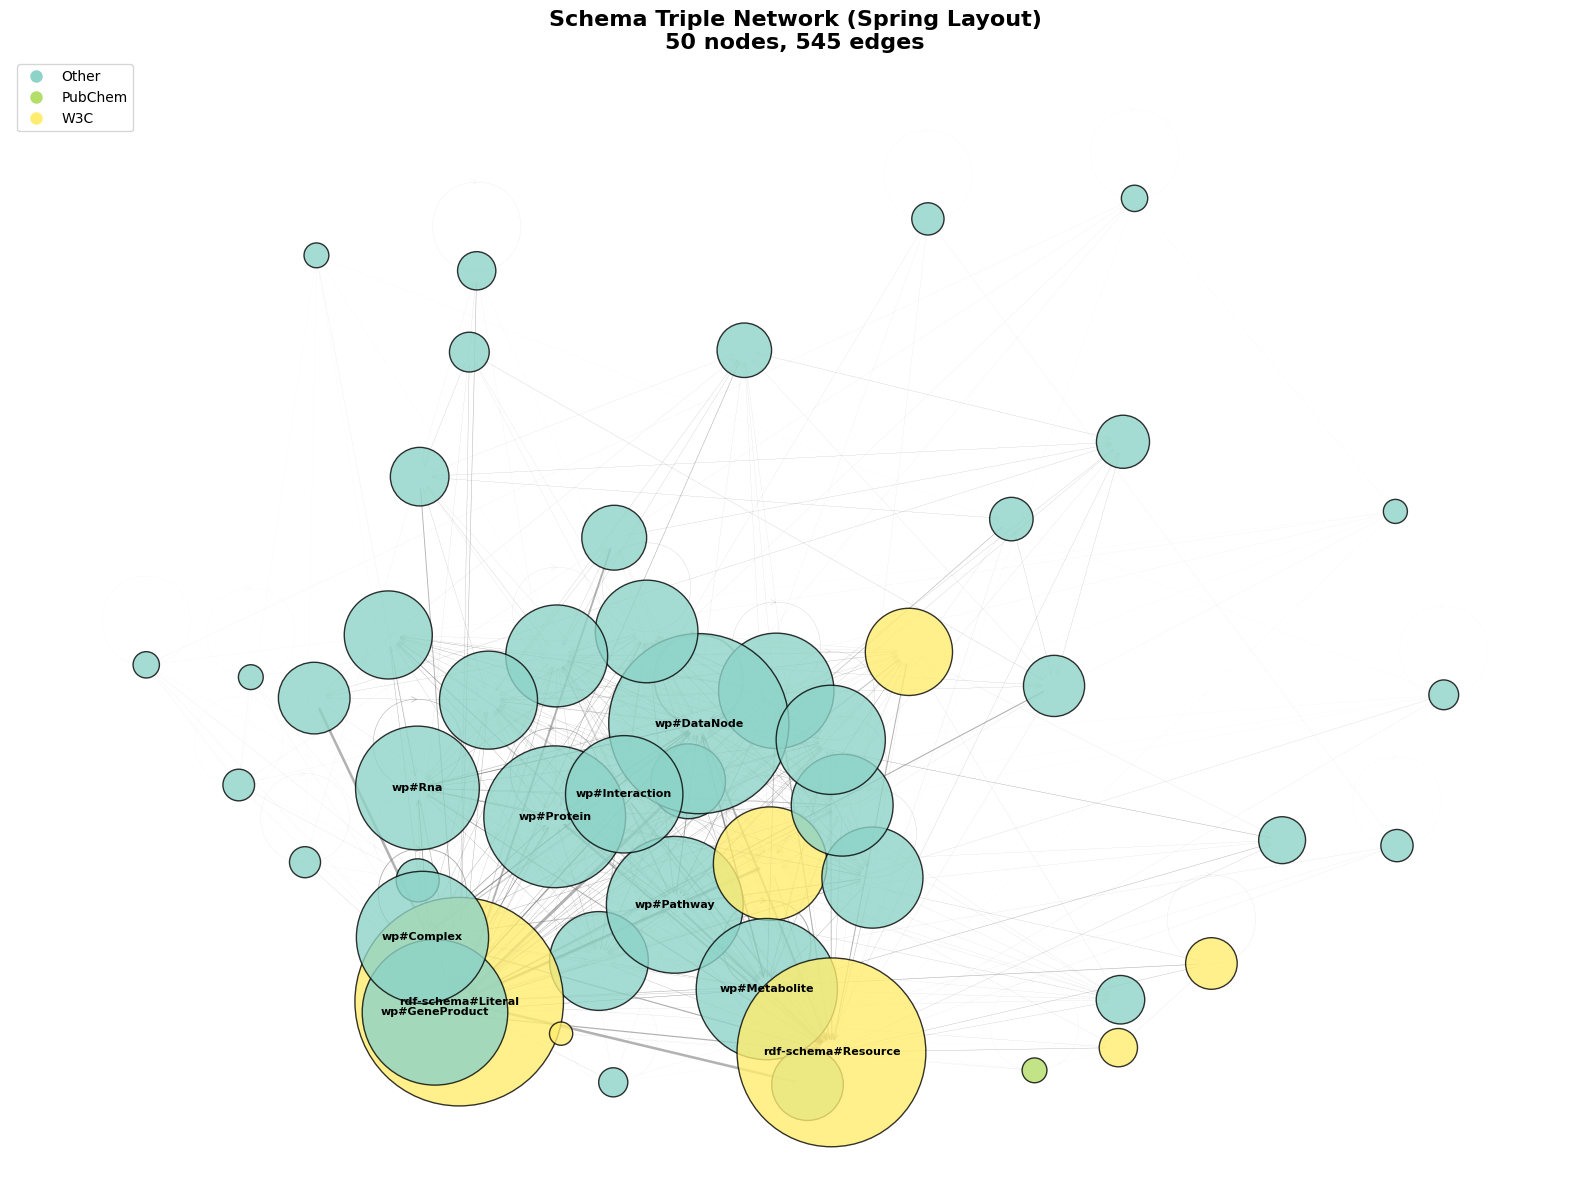


Network Visualization Summary:
  Displayed nodes: 50
  Displayed edges: 545
  Node types: 3
  Edge weight range: 1 - 100

--- Shell Layout ---
Visualization limited to top 50 nodes by degree


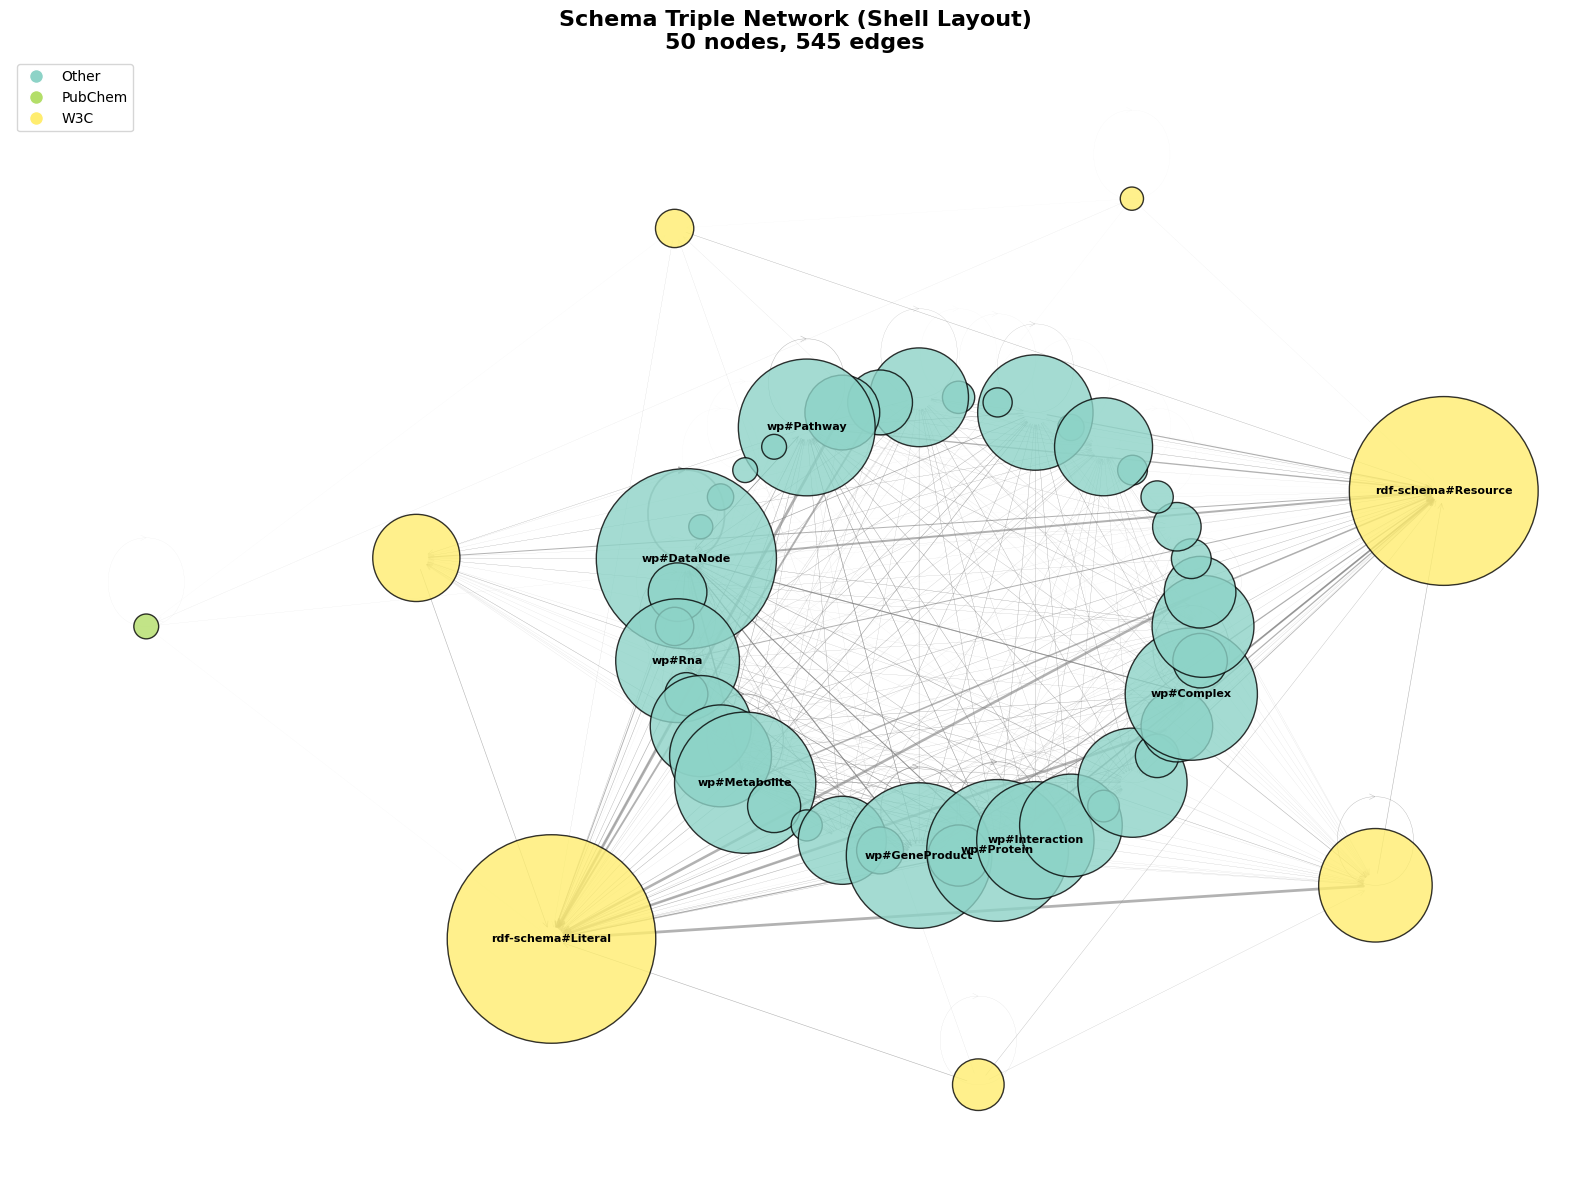


Network Visualization Summary:
  Displayed nodes: 50
  Displayed edges: 545
  Node types: 3
  Edge weight range: 1 - 100
URI Type Subgraph Analysis:

W3C subgraph:
  Nodes: 14
  Edges: 472
  Density: 2.5934


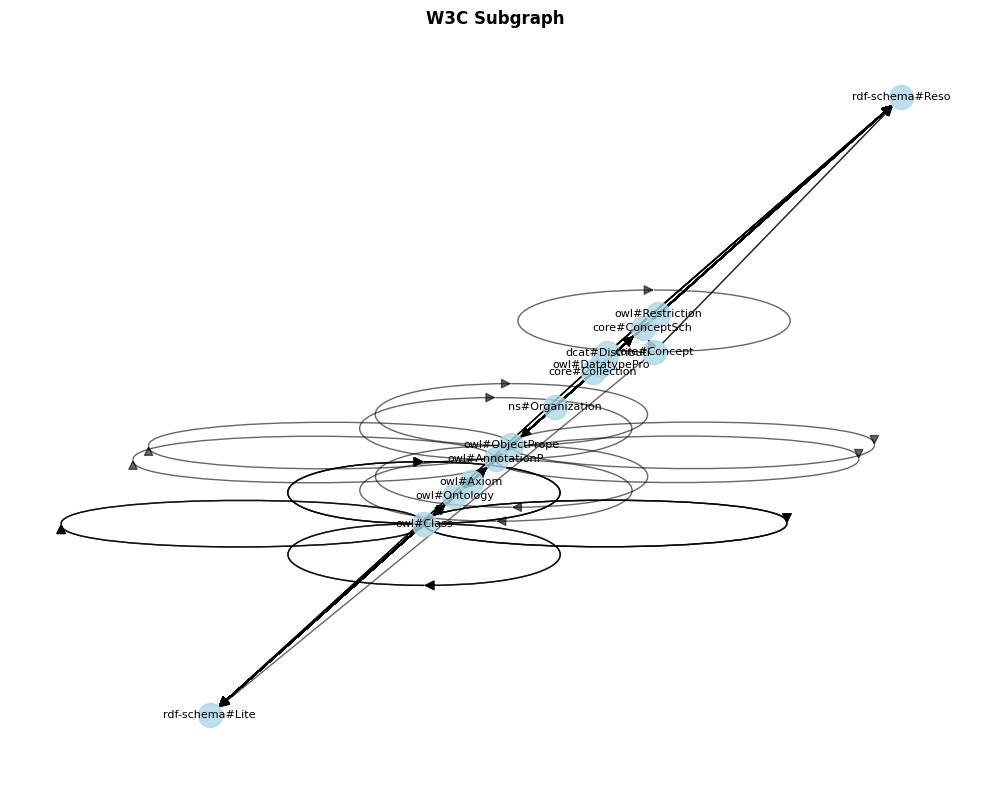


PubChem subgraph:
  Nodes: 15
  Edges: 2
  Density: 0.0095


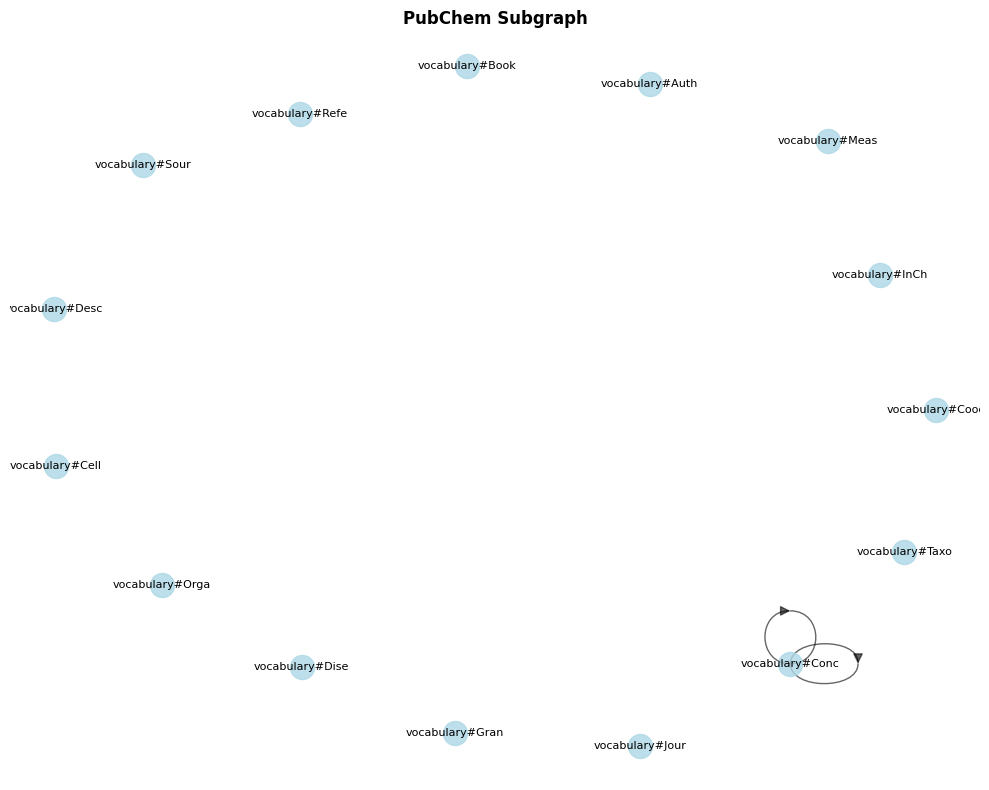


PURL subgraph:
  Nodes: 4
  Edges: 0
  Density: 0.0000

Other subgraph:
  Nodes: 69
  Edges: 3060
  Density: 0.6522

FOAF subgraph:
  Nodes: 2
  Edges: 0
  Density: 0.0000


In [ ]:
def visualize_triple_network(G, layout_type='spring', max_nodes=50):
    """
    Visualize the schema triple network with enhanced styling
    """
    # Convert to simple graph for visualization (remove multiple edges)
    simple_G = nx.DiGraph()
    
    # Add nodes with aggregated edge information
    for node in G.nodes():
        simple_G.add_node(node, **G.nodes[node])
    
    # Add edges (combining multiple edges between same nodes)
    edge_weights = defaultdict(int)
    edge_predicates = defaultdict(set)
    
    for source, target, edge_data in G.edges(data=True):
        edge_weights[(source, target)] += 1
        edge_predicates[(source, target)].add(edge_data['predicate'])
    
    for (source, target), weight in edge_weights.items():
        simple_G.add_edge(source, target, 
                         weight=weight, 
                         predicates=list(edge_predicates[(source, target)]),
                         predicate_count=len(edge_predicates[(source, target)]))
    
    # Limit nodes for visualization if graph is too large
    if simple_G.number_of_nodes() > max_nodes:
        # Keep top degree nodes
        top_nodes = sorted(simple_G.degree(), key=lambda x: x[1], reverse=True)[:max_nodes]
        nodes_to_keep = [node for node, degree in top_nodes]
        simple_G = simple_G.subgraph(nodes_to_keep).copy()
        print(f"Visualization limited to top {max_nodes} nodes by degree")
    
    plt.figure(figsize=(16, 12))
    
    # Choose layout
    if layout_type == 'spring':
        pos = nx.spring_layout(simple_G, k=3, iterations=50)
    elif layout_type == 'circular':
        pos = nx.circular_layout(simple_G)
    elif layout_type == 'shell':
        # Group nodes by type for shell layout
        uri_types = defaultdict(list)
        for node in simple_G.nodes():
            uri_type = simple_G.nodes[node]['uri_type']
            uri_types[uri_type].append(node)
        shells = [nodes for nodes in uri_types.values() if len(nodes) > 0]
        pos = nx.shell_layout(simple_G, nlist=shells) if len(shells) > 1 else nx.circular_layout(simple_G)
    else:
        pos = nx.random_layout(simple_G)
    
    # Color nodes by URI type
    uri_types = [simple_G.nodes[node]['uri_type'] for node in simple_G.nodes()]
    unique_types = list(set(uri_types))
    type_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_types)))
    type_color_map = {uri_type: type_colors[i] for i, uri_type in enumerate(unique_types)}
    node_colors = [type_color_map[uri_type] for uri_type in uri_types]
    
    # Size nodes by degree
    node_sizes = [simple_G.nodes[node]['total_degree'] * 20 + 100 for node in simple_G.nodes()]
    
    # Draw nodes
    nx.draw_networkx_nodes(simple_G, pos,
                          node_color=node_colors,
                          node_size=node_sizes,
                          alpha=0.8,
                          linewidths=1,
                          edgecolors='black')
    
    # Draw edges with varying thickness based on weight
    edge_weights = [simple_G[u][v]['weight'] for u, v in simple_G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    
    nx.draw_networkx_edges(simple_G, pos,
                          width=[w * 2 / max_weight for w in edge_weights],
                          alpha=0.6,
                          edge_color='gray',
                          arrowsize=10,
                          arrowstyle='->')
    
    # Add labels for high-degree nodes
    high_degree_nodes = [node for node in simple_G.nodes() 
                        if simple_G.nodes[node]['total_degree'] >= np.percentile([simple_G.nodes[n]['total_degree'] for n in simple_G.nodes()], 80)]
    
    high_degree_labels = {}
    for node in high_degree_nodes:
        # Shorten URI for display
        if '/' in node:
            label = node.split('/')[-1]
        elif '#' in node:
            label = node.split('#')[-1]
        else:
            label = node[-20:]  # Last 20 characters
        high_degree_labels[node] = label
    
    nx.draw_networkx_labels(simple_G, pos, high_degree_labels, 
                           font_size=8, font_weight='bold')
    
    plt.title(f'Schema Triple Network ({layout_type.title()} Layout)\n'
              f'{simple_G.number_of_nodes()} nodes, {simple_G.number_of_edges()} edges', 
              fontsize=16, fontweight='bold')
    plt.axis('off')
    
    # Create legend for node colors
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=type_color_map[uri_type], 
                                 markersize=10, label=uri_type)
                      for uri_type in unique_types]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))
    
    plt.tight_layout()
    plt.show()
    
    # Print network summary
    print(f"\nNetwork Visualization Summary:")
    print(f"  Displayed nodes: {simple_G.number_of_nodes()}")
    print(f"  Displayed edges: {simple_G.number_of_edges()}")
    print(f"  Node types: {len(unique_types)}")
    print(f"  Edge weight range: {min(edge_weights) if edge_weights else 0} - {max(edge_weights) if edge_weights else 0}")

def create_uri_type_subgraphs(G):
    """
    Create and visualize subgraphs for each URI type
    """
    uri_type_nodes = defaultdict(list)
    for node in G.nodes():
        uri_type = G.nodes[node]['uri_type']
        uri_type_nodes[uri_type].append(node)
    
    print(f"URI Type Subgraph Analysis:")
    print("=" * 40)
    
    for uri_type, nodes in uri_type_nodes.items():
        if len(nodes) > 1:  # Only analyze types with multiple nodes
            subgraph = G.subgraph(nodes)
            print(f"\n{uri_type} subgraph:")
            print(f"  Nodes: {subgraph.number_of_nodes()}")
            print(f"  Edges: {subgraph.number_of_edges()}")
            print(f"  Density: {nx.density(subgraph):.4f}")
            
            if subgraph.number_of_edges() > 0:
                # Visualize if reasonably sized
                if subgraph.number_of_nodes() <= 20:
                    plt.figure(figsize=(10, 8))
                    pos = nx.spring_layout(subgraph)
                    
                    nx.draw_networkx_nodes(subgraph, pos, 
                                         node_color='lightblue',
                                         node_size=300,
                                         alpha=0.8)
                    
                    nx.draw_networkx_edges(subgraph, pos,
                                         alpha=0.6,
                                         arrowsize=15)
                    
                    # Add shortened labels
                    labels = {}
                    for node in subgraph.nodes():
                        if '/' in node:
                            labels[node] = node.split('/')[-1][:15]
                        elif '#' in node:
                            labels[node] = node.split('#')[-1][:15]
                        else:
                            labels[node] = node[-15:]
                    
                    nx.draw_networkx_labels(subgraph, pos, labels, font_size=8)
                    
                    plt.title(f'{uri_type} Subgraph', fontweight='bold')
                    plt.axis('off')
                    plt.tight_layout()
                    plt.show()

# Create visualizations with different layouts
print("Creating Triple Network Visualizations...")

layouts = ['spring', 'shell']
for layout in layouts:
    print(f"\n--- {layout.title()} Layout ---")
    visualize_triple_network(G, layout)

# Create URI type subgraph analysis
create_uri_type_subgraphs(G)

## Community Detection

Apply community detection algorithms to identify clusters or groups within the schema network.

In [ ]:
def detect_communities(G: nx.DiGraph):
    """
    Detect communities in the schema network using multiple algorithms.
    """
    # Convert to simple directed graph first
    simple_G = nx.DiGraph()
    
    # Add nodes
    for node in G.nodes():
        simple_G.add_node(node, **G.nodes[node])
    
    # Add simplified edges (remove multi-edges)
    edge_counts = defaultdict(int)
    for source, target in G.edges():
        edge_counts[(source, target)] += 1
    
    for (source, target), count in edge_counts.items():
        simple_G.add_edge(source, target, weight=count)
    
    # Convert to undirected for community detection
    G_undirected = simple_G.to_undirected()
    
    communities = {}
    
    # Louvain algorithm (if available)
    try:
        import community as community_louvain
        partition = community_louvain.best_partition(G_undirected)
        communities['louvain'] = partition
        print("Louvain algorithm applied successfully")
    except ImportError:
        print("Community package not available, using alternative methods")
    
    # Greedy modularity communities
    try:
        greedy_communities = list(nx.community.greedy_modularity_communities(G_undirected))
        greedy_partition = {}
        for i, community_set in enumerate(greedy_communities):
            for node in community_set:
                greedy_partition[node] = i
        communities['greedy_modularity'] = greedy_partition
        print("Greedy modularity algorithm applied successfully")
    except:
        print("Greedy modularity algorithm failed")
    
    # Label propagation
    try:
        label_communities = list(nx.community.label_propagation_communities(G_undirected))
        label_partition = {}
        for i, community_set in enumerate(label_communities):
            for node in community_set:
                label_partition[node] = i
        communities['label_propagation'] = label_partition
        print("Label propagation algorithm applied successfully")
    except:
        print("Label propagation algorithm failed")
    
    return communities

# Detect communities
communities = detect_communities(G)

# Analyze and visualize communities
for method, partition in communities.items():
    print(f"\n{method.replace('_', ' ').title()} Communities:")
    print("=" * 40)
    
    community_groups = defaultdict(list)
    for node, community_id in partition.items():
        community_groups[community_id].append(node)
    
    # Show community composition
    for community_id, nodes in community_groups.items():
        print(f"Community {community_id} ({len(nodes)} nodes):")
        # Show URI types in this community
        uri_types_in_community = Counter()
        for node in nodes:
            uri_type = G.nodes[node]['uri_type']
            uri_types_in_community[uri_type] += 1
        
        print(f"  URI types: {dict(uri_types_in_community)}")
        
        # Show a few example nodes
        sample_nodes = nodes[:5]
        for node in sample_nodes:
            short_name = node.split('/')[-1] if '/' in node else node.split('#')[-1] if '#' in node else node[-20:]
            print(f"    - {short_name} ({G.nodes[node]['uri_type']})")
        if len(nodes) > 5:
            print(f"    ... and {len(nodes) - 5} more nodes")
        print()
    
    # Visualize communities (limit to reasonable size)
    if len(partition) <= 100:  # Only visualize if not too many nodes
        plt.figure(figsize=(14, 10))
        
        # Create a simplified graph for visualization
        simple_G = nx.DiGraph()
        for node in G.nodes():
            simple_G.add_node(node, **G.nodes[node])
        
        # Add simplified edges
        edge_counts = defaultdict(int)
        for source, target in G.edges():
            edge_counts[(source, target)] += 1
        
        for (source, target), count in edge_counts.items():
            simple_G.add_edge(source, target, weight=count)
        
        pos = nx.spring_layout(simple_G, k=3, iterations=50)
        
        # Color nodes by community
        node_colors = [partition[node] for node in simple_G.nodes()]
        
        # Size nodes by degree
        node_sizes = [simple_G.degree(node) * 50 + 100 for node in simple_G.nodes()]
        
        nx.draw_networkx_nodes(simple_G, pos, 
                              node_color=node_colors,
                              cmap='Set3',
                              node_size=node_sizes,
                              alpha=0.8)
        
        nx.draw_networkx_edges(simple_G, pos, alpha=0.3, arrowsize=10, width=0.5)
        
        # Add labels for high-degree nodes only
        high_degree_nodes = [node for node in simple_G.nodes() if simple_G.degree(node) >= 5]
        labels = {}
        for node in high_degree_nodes:
            short_name = node.split('/')[-1] if '/' in node else node.split('#')[-1] if '#' in node else node[-15:]
            labels[node] = short_name
        
        nx.draw_networkx_labels(simple_G, pos, labels, font_size=8, font_weight='bold')
        
        plt.title(f'RDF Triple Communities ({method.replace("_", " ").title()})', 
                  fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Calculate modularity
        if len(community_groups) > 1:
            G_undirected = simple_G.to_undirected()
            modularity = nx.community.modularity(G_undirected, community_groups.values())
            print(f"Modularity score: {modularity:.4f}")
    else:
        print(f"Graph too large ({len(partition)} nodes) for visualization")
        
        # Calculate modularity anyway
        if len(community_groups) > 1:
            simple_G = nx.DiGraph()
            for node in G.nodes():
                simple_G.add_node(node)
            
            edge_counts = defaultdict(int)
            for source, target in G.edges():
                edge_counts[(source, target)] += 1
            
            for (source, target), count in edge_counts.items():
                simple_G.add_edge(source, target, weight=count)
            
            G_undirected = simple_G.to_undirected()
            modularity = nx.community.modularity(G_undirected, community_groups.values())
            print(f"Modularity score: {modularity:.4f}")

Community package not available, using alternative methods
Greedy modularity algorithm applied successfully
Label propagation algorithm applied successfully

Greedy Modularity Communities:
Community 0 (48 nodes):
  URI types: {'Other': 26, 'W3C': 3, 'PubChem': 14, 'PURL': 4, 'Dublin Core': 1}
    - aop_ontology#OrganContext (Other)
    - dcat#Distribution (W3C)
    - vocabulary#Organization (PubChem)
    - vocabulary#Grant (PubChem)
    - vocabulary#Author (PubChem)
    ... and 43 more nodes

Community 1 (24 nodes):
  URI types: {'W3C': 10, 'Other': 13, 'PubChem': 1}
    - owl#AnnotationProperty (W3C)
    - core#ConceptScheme (W3C)
    - gpml#Comment (Other)
    - owl#Restriction (W3C)
    - owl#DatatypeProperty (W3C)
    ... and 19 more nodes

Community 2 (21 nodes):
  URI types: {'Other': 18, 'FOAF': 2, 'W3C': 1}
    - wp#DirectedInteraction (Other)
    - wp#Conversion (Other)
    - Person (FOAF)
    - wp#Stimulation (Other)
    - wp#Metabolite (Other)
    ... and 16 more nodes

Comm

## Centrality Measures

Calculate various centrality measures (degree, betweenness, closeness, eigenvector) to identify important schemas.

Computing centrality measures for triple network...
Simplified graph for centrality: 105 nodes, 704 edges
Calculating degree centrality...
Calculating closeness centrality...
Calculating betweenness centrality...
Calculating eigenvector centrality...
Calculating PageRank...

Top 15 Nodes by Different Centrality Measures:

Degree Centrality:
  rdf-schema#Resource (W3C): 0.9808
  rdf-schema#Literal (W3C): 0.9615
  wp#PublicationReference (Other): 0.5000
  gpml#PublicationXref (Other): 0.4808
  owl#Class (W3C): 0.4231

Closeness Centrality:
  rdf-schema#Resource (W3C): 0.9811
  rdf-schema#Literal (W3C): 0.9630
  owl#Class (W3C): 0.6190
  gpml#PublicationXref (Other): 0.5746
  wp#PublicationReference (Other): 0.5746

Betweenness Centrality:
  rdf-schema#Resource (W3C): 0.4463
  rdf-schema#Literal (W3C): 0.4187
  owl#Class (W3C): 0.0302
  gpml#PublicationXref (Other): 0.0053
  wp#PublicationReference (Other): 0.0053

Eigenvector Centrality:
  rdf-schema#Resource (W3C): 0.2923
  rdf-schema#L

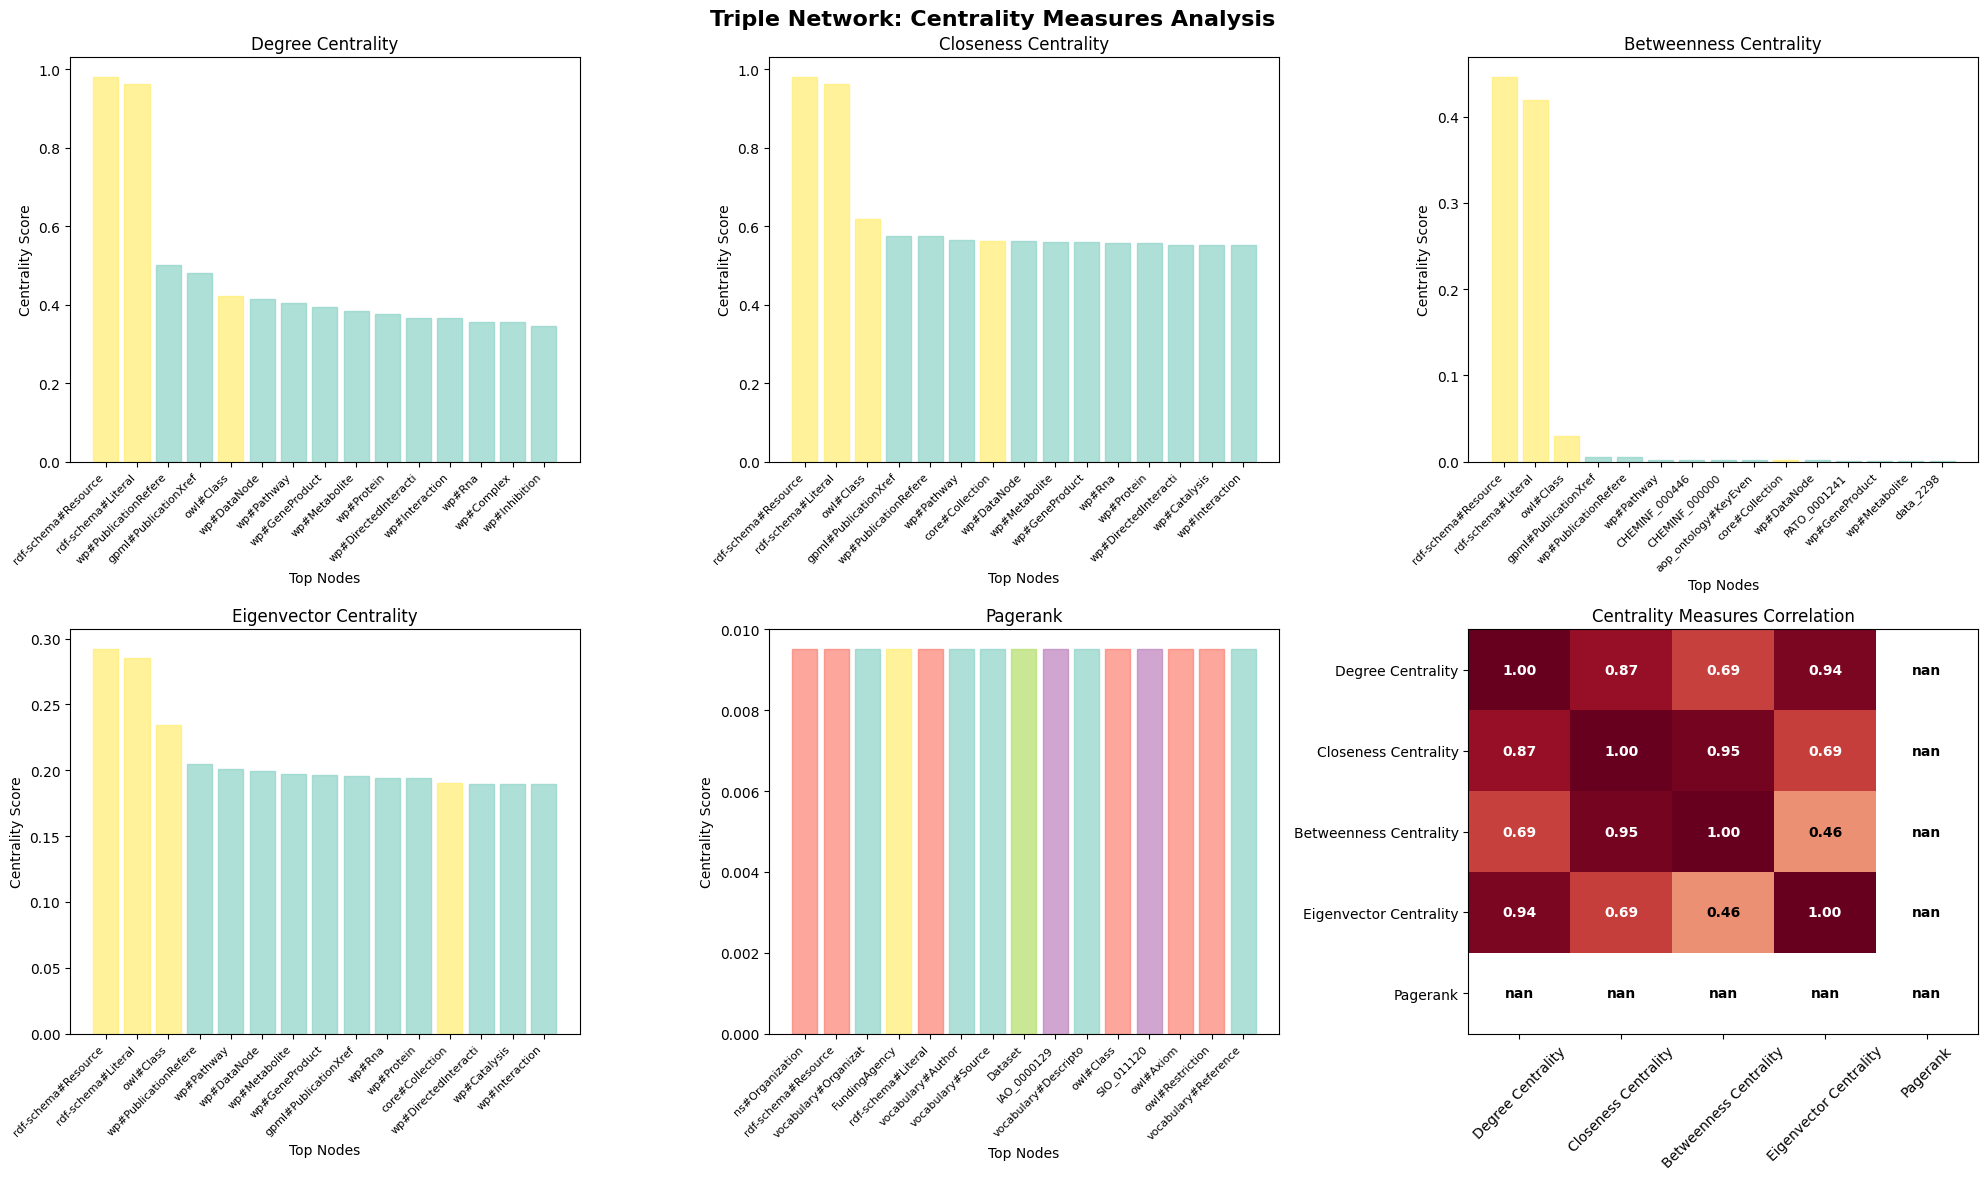


Centrality by URI Type Analysis:

W3C (14 nodes):
  Avg degree centrality: 0.2246
  Avg PageRank: 0.009524
  Max betweenness: 0.4463
  Nodes with high centrality (top 25%): 14

PubChem (15 nodes):
  Avg degree centrality: 0.0224
  Avg PageRank: 0.009524
  Max betweenness: 0.0000
  Nodes with high centrality (top 25%): 15

PURL (4 nodes):
  Avg degree centrality: 0.0192
  Avg PageRank: 0.009524
  Max betweenness: 0.0000
  Nodes with high centrality (top 25%): 4

Dublin Core (1 nodes):
  Avg degree centrality: 0.0192
  Avg PageRank: 0.009524
  Max betweenness: 0.0000
  Nodes with high centrality (top 25%): 1

Other (69 nodes):
  Avg degree centrality: 0.1431
  Avg PageRank: 0.009524
  Max betweenness: 0.0053
  Nodes with high centrality (top 25%): 69

FOAF (2 nodes):
  Avg degree centrality: 0.0433
  Avg PageRank: 0.009524
  Max betweenness: 0.0000
  Nodes with high centrality (top 25%): 2

Centrality Measures Correlation Matrix:
                        degree_centrality  closeness_cent

In [ ]:
def calculate_triple_centrality_measures(G) -> pd.DataFrame:
    """
    Calculate various centrality measures for the triple network.
    """
    centrality_data = []
    
    # Convert to simple directed graph for centrality calculations
    simple_G = nx.DiGraph()
    
    # Add nodes
    for node in G.nodes():
        simple_G.add_node(node, **G.nodes[node])
    
    # Add simplified edges (remove multi-edges)
    edge_counts = defaultdict(int)
    for source, target in G.edges():
        edge_counts[(source, target)] += 1
    
    for (source, target), count in edge_counts.items():
        simple_G.add_edge(source, target, weight=count)
    
    print(f"Simplified graph for centrality: {simple_G.number_of_nodes()} nodes, {simple_G.number_of_edges()} edges")
    
    # Convert to undirected for some centrality measures
    G_undirected = simple_G.to_undirected()
    
    # Calculate centrality measures
    print("Calculating degree centrality...")
    degree_centrality = nx.degree_centrality(simple_G)
    in_degree_centrality = nx.in_degree_centrality(simple_G)
    out_degree_centrality = nx.out_degree_centrality(simple_G)
    
    # Closeness centrality (handle disconnected components)
    print("Calculating closeness centrality...")
    try:
        if nx.is_connected(G_undirected):
            closeness_centrality = nx.closeness_centrality(G_undirected)
        else:
            # Calculate for each component separately
            closeness_centrality = {}
            for component in nx.connected_components(G_undirected):
                if len(component) > 1:
                    subgraph = G_undirected.subgraph(component)
                    component_closeness = nx.closeness_centrality(subgraph)
                    closeness_centrality.update(component_closeness)
                else:
                    # Single node component
                    closeness_centrality[list(component)[0]] = 0.0
    except:
        closeness_centrality = {node: 0 for node in simple_G.nodes()}
    
    # Betweenness centrality
    print("Calculating betweenness centrality...")
    try:
        if nx.is_connected(G_undirected):
            betweenness_centrality = nx.betweenness_centrality(G_undirected)
        else:
            # Calculate for largest component only
            largest_cc = max(nx.connected_components(G_undirected), key=len)
            if len(largest_cc) > 2:
                subgraph = G_undirected.subgraph(largest_cc)
                component_betweenness = nx.betweenness_centrality(subgraph)
                betweenness_centrality = {node: component_betweenness.get(node, 0) for node in simple_G.nodes()}
            else:
                betweenness_centrality = {node: 0 for node in simple_G.nodes()}
    except:
        betweenness_centrality = {node: 0 for node in simple_G.nodes()}
    
    # Eigenvector centrality (handle disconnected components)
    print("Calculating eigenvector centrality...")
    try:
        if nx.is_connected(G_undirected) and len(G_undirected) > 1:
            eigenvector_centrality = nx.eigenvector_centrality(G_undirected, max_iter=1000)
        else:
            # Calculate for largest component only
            largest_cc = max(nx.connected_components(G_undirected), key=len)
            if len(largest_cc) > 1:
                subgraph = G_undirected.subgraph(largest_cc)
                component_eigenvector = nx.eigenvector_centrality(subgraph, max_iter=1000)
                eigenvector_centrality = {node: component_eigenvector.get(node, 0) for node in simple_G.nodes()}
            else:
                eigenvector_centrality = {node: 1/len(simple_G) for node in simple_G.nodes()}
    except:
        eigenvector_centrality = {node: 1/len(simple_G) for node in simple_G.nodes()}
    
    # PageRank
    print("Calculating PageRank...")
    try:
        pagerank = nx.pagerank(simple_G, max_iter=1000)
    except:
        pagerank = {node: 1/len(simple_G) for node in simple_G.nodes()}
    
    # Compile data
    for node in simple_G.nodes():
        node_data = simple_G.nodes[node]
        centrality_data.append({
            'uri': node,
            'uri_type': node_data['uri_type'],
            'total_degree': node_data['total_degree'],
            'source_count': len(node_data['sources']),
            'degree_centrality': degree_centrality[node],
            'in_degree_centrality': in_degree_centrality[node],
            'out_degree_centrality': out_degree_centrality[node],
            'closeness_centrality': closeness_centrality[node],
            'betweenness_centrality': betweenness_centrality[node],
            'eigenvector_centrality': eigenvector_centrality[node],
            'pagerank': pagerank[node]
        })
    
    return pd.DataFrame(centrality_data)

# Calculate centrality measures
print("Computing centrality measures for triple network...")
centrality_df = calculate_triple_centrality_measures(G)

print("\nTop 15 Nodes by Different Centrality Measures:")
print("=" * 60)

centrality_measures = [
    'degree_centrality', 'closeness_centrality', 'betweenness_centrality', 
    'eigenvector_centrality', 'pagerank'
]

for measure in centrality_measures:
    print(f"\n{measure.replace('_', ' ').title()}:")
    top_nodes = centrality_df.nlargest(5, measure)
    for idx, row in top_nodes.iterrows():
        uri_short = row['uri'].split('/')[-1] if '/' in row['uri'] else row['uri'].split('#')[-1] if '#' in row['uri'] else row['uri'][-30:]
        print(f"  {uri_short[:40]} ({row['uri_type']}): {row[measure]:.4f}")

# Create centrality visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Triple Network: Centrality Measures Analysis', fontsize=16, fontweight='bold')

# Individual centrality measure plots
for i, measure in enumerate(centrality_measures):
    row, col = i // 3, i % 3
    
    # Top 15 nodes for this measure
    top_15 = centrality_df.nlargest(15, measure)
    
    # Create shortened labels
    labels = []
    for uri in top_15['uri']:
        if '/' in uri:
            label = uri.split('/')[-1][:20]
        elif '#' in uri:
            label = uri.split('#')[-1][:20]
        else:
            label = uri[-20:]
        labels.append(label)
    
    bars = axes[row, col].bar(range(len(top_15)), top_15[measure], alpha=0.7)
    axes[row, col].set_title(measure.replace('_', ' ').title())
    axes[row, col].set_xlabel('Top Nodes')
    axes[row, col].set_ylabel('Centrality Score')
    axes[row, col].set_xticks(range(len(top_15)))
    axes[row, col].set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    
    # Color bars by URI type
    uri_types = top_15['uri_type'].values
    unique_types = list(set(uri_types))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_types)))
    color_map = {uri_type: colors[j] for j, uri_type in enumerate(unique_types)}
    
    for bar, uri_type in zip(bars, uri_types):
        bar.set_color(color_map[uri_type])

# Correlation heatmap
axes[1, 2].clear()
corr_matrix = centrality_df[centrality_measures].corr()
im = axes[1, 2].imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
axes[1, 2].set_title('Centrality Measures Correlation')
axes[1, 2].set_xticks(range(len(centrality_measures)))
axes[1, 2].set_yticks(range(len(centrality_measures)))
axes[1, 2].set_xticklabels([m.replace('_', ' ').title() for m in centrality_measures], rotation=45)
axes[1, 2].set_yticklabels([m.replace('_', ' ').title() for m in centrality_measures])

# Add correlation values to heatmap
for i in range(len(centrality_measures)):
    for j in range(len(centrality_measures)):
        color = 'white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black'
        axes[1, 2].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                       ha='center', va='center', color=color, fontweight='bold')

plt.tight_layout()
plt.show()

# URI type analysis
print(f"\nCentrality by URI Type Analysis:")
print("=" * 50)

for uri_type in centrality_df['uri_type'].unique():
    type_data = centrality_df[centrality_df['uri_type'] == uri_type]
    if len(type_data) > 0:
        print(f"\n{uri_type} ({len(type_data)} nodes):")
        print(f"  Avg degree centrality: {type_data['degree_centrality'].mean():.4f}")
        print(f"  Avg PageRank: {type_data['pagerank'].mean():.6f}")
        print(f"  Max betweenness: {type_data['betweenness_centrality'].max():.4f}")
        print(f"  Nodes with high centrality (top 25%): {len(type_data[type_data['pagerank'] >= type_data['pagerank'].quantile(0.75)])}")

print(f"\nCentrality Measures Correlation Matrix:")
print(corr_matrix.round(3))

## Path Analysis

Analyze shortest paths, path lengths, and connectivity patterns between different schema nodes.

Path Analysis Results:
Average Path Length: 1.9075091575091576
Max Path Length: 2
Min Path Length: 1
Path Length Std: 0.2897175979228336
Diameter: 2
Radius: 2
Center Nodes: ['http://www.w3.org/2006/vcard/ns#Organization', 'http://www.w3.org/2000/01/rdf-schema#Resource', 'http://rdf.ncbi.nlm.nih.gov/pubchem/vocabulary#Organization', 'http://purl.org/cerif/frapo/FundingAgency', 'http://www.w3.org/2000/01/rdf-schema#Literal', 'http://rdf.ncbi.nlm.nih.gov/pubchem/vocabulary#Author', 'http://rdf.ncbi.nlm.nih.gov/pubchem/vocabulary#Source', 'http://purl.org/dc/terms/Dataset', 'http://purl.obolibrary.org/obo/IAO_0000129', 'http://rdf.ncbi.nlm.nih.gov/pubchem/vocabulary#Descriptor', 'http://www.w3.org/2002/07/owl#Class', 'http://semanticscience.org/resource/SIO_011120', 'http://www.w3.org/2002/07/owl#Axiom', 'http://www.w3.org/2002/07/owl#Restriction', 'http://rdf.ncbi.nlm.nih.gov/pubchem/vocabulary#Reference', 'http://www.bioassayontology.org/bao#BAO_0000040', 'http://rdf.ncbi.nlm.nih.gov/pub

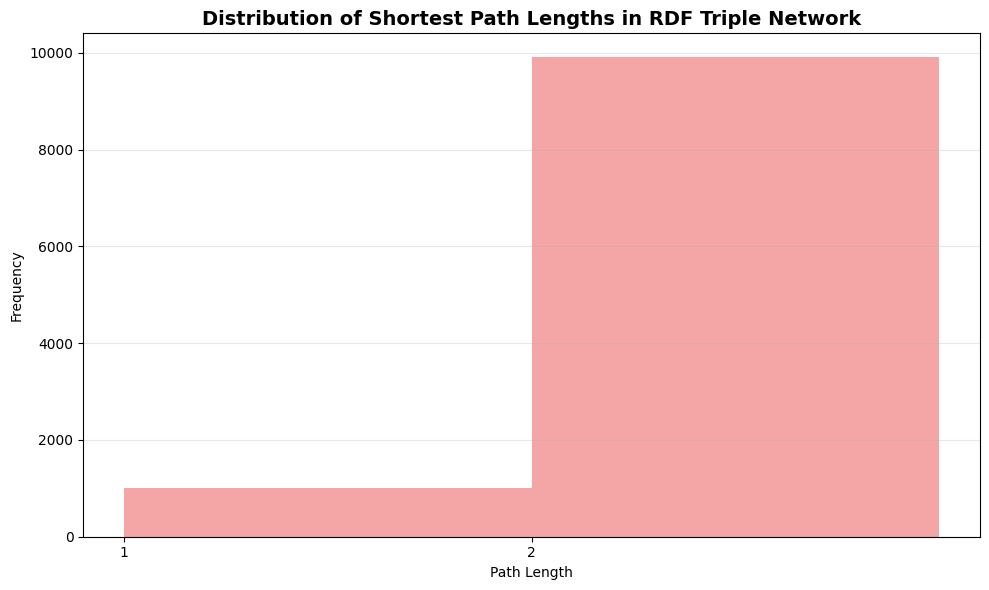


Path length statistics:
  Mean: 1.91
  Median: 2.00
  Standard deviation: 0.29


In [ ]:
def analyze_paths(G: nx.DiGraph) -> Dict:
    """
    Analyze path-related properties of the schema network.
    """
    path_analysis = {}
    
    # Convert to simple directed graph first (remove multi-edges)
    simple_G = nx.DiGraph()
    
    # Add nodes
    for node in G.nodes():
        simple_G.add_node(node, **G.nodes[node])
    
    # Add simplified edges
    edge_counts = defaultdict(int)
    for source, target in G.edges():
        edge_counts[(source, target)] += 1
    
    for (source, target), count in edge_counts.items():
        simple_G.add_edge(source, target, weight=count)
    
    # Convert to undirected for path analysis
    G_undirected = simple_G.to_undirected()
    
    # All pairs shortest path lengths
    if nx.is_connected(G_undirected):
        path_lengths = dict(nx.all_pairs_shortest_path_length(G_undirected))
        
        # Flatten path lengths for analysis
        all_path_lengths = []
        for source, targets in path_lengths.items():
            for target, length in targets.items():
                if source != target:  # Exclude self-paths
                    all_path_lengths.append(length)
        
        path_analysis['average_path_length'] = np.mean(all_path_lengths)
        path_analysis['max_path_length'] = max(all_path_lengths)
        path_analysis['min_path_length'] = min(all_path_lengths)
        path_analysis['path_length_std'] = np.std(all_path_lengths)
        
        # Diameter and radius
        path_analysis['diameter'] = nx.diameter(G_undirected)
        path_analysis['radius'] = nx.radius(G_undirected)
        
        # Eccentricity
        eccentricity = nx.eccentricity(G_undirected)
        path_analysis['eccentricity'] = eccentricity
        
        # Center and periphery
        center = nx.center(G_undirected)
        periphery = nx.periphery(G_undirected)
        path_analysis['center_nodes'] = center
        path_analysis['periphery_nodes'] = periphery
        
    else:
        path_analysis['average_path_length'] = 'N/A (disconnected)'
        path_analysis['diameter'] = 'N/A (disconnected)'
        path_analysis['radius'] = 'N/A (disconnected)'
        path_analysis['center_nodes'] = []
        path_analysis['periphery_nodes'] = []
        
        # Analyze each component separately
        components = list(nx.connected_components(G_undirected))
        path_analysis['components'] = components
        path_analysis['component_sizes'] = [len(comp) for comp in components]
    
    return path_analysis, simple_G

# Perform path analysis
path_analysis, simple_G = analyze_paths(G)

print("Path Analysis Results:")
print("=" * 40)
for key, value in path_analysis.items():
    if key not in ['eccentricity', 'components']:
        print(f"{key.replace('_', ' ').title()}: {value}")

# Display eccentricity information (top 10 most eccentric nodes)
if 'eccentricity' in path_analysis:
    print(f"\nTop 10 Most Eccentric Nodes:")
    sorted_ecc = sorted(path_analysis['eccentricity'].items(), key=lambda x: x[1], reverse=True)[:10]
    for node, ecc in sorted_ecc:
        short_name = node.split('/')[-1] if '/' in node else node.split('#')[-1] if '#' in node else node[-30:]
        uri_type = G.nodes[node]['uri_type']
        print(f"  {short_name} ({uri_type}): eccentricity {ecc}")

# Display component information if disconnected
if 'components' in path_analysis:
    print(f"\nConnected Components Analysis:")
    components = path_analysis['components']
    component_sizes = path_analysis['component_sizes']
    
    print(f"Number of components: {len(components)}")
    print(f"Largest component size: {max(component_sizes)}")
    print(f"Smallest component size: {min(component_sizes)}")
    print(f"Average component size: {np.mean(component_sizes):.2f}")
    
    # Show details of largest components
    largest_components = sorted(zip(components, component_sizes), key=lambda x: x[1], reverse=True)[:5]
    for i, (component, size) in enumerate(largest_components):
        print(f"\nComponent {i+1} (size {size}):")
        # Show URI types in this component
        uri_types_in_comp = Counter()
        for node in component:
            uri_type = G.nodes[node]['uri_type']
            uri_types_in_comp[uri_type] += 1
        print(f"  URI types: {dict(uri_types_in_comp)}")
        
        # Show sample nodes
        sample_nodes = list(component)[:5]
        for node in sample_nodes:
            short_name = node.split('/')[-1] if '/' in node else node.split('#')[-1] if '#' in node else node[-20:]
            print(f"    - {short_name} ({G.nodes[node]['uri_type']})")
        if len(component) > 5:
            print(f"    ... and {len(component) - 5} more nodes")

# Shortest paths between all pairs (sample analysis)
print(f"\nShortest Paths Sample Analysis:")
print("=" * 40)

G_undirected = simple_G.to_undirected()
if nx.is_connected(G_undirected):
    # Sample some paths between high-degree nodes
    high_degree_nodes = sorted(simple_G.degree(), key=lambda x: x[1], reverse=True)[:10]
    high_degree_node_list = [node for node, degree in high_degree_nodes]
    
    if len(high_degree_node_list) >= 2:
        paths = dict(nx.all_pairs_shortest_path(G_undirected))
        print(f"Sample shortest paths between high-degree nodes:")
        
        sample_count = 0
        for i in range(min(3, len(high_degree_node_list))):
            for j in range(i+1, min(i+3, len(high_degree_node_list))):
                if sample_count >= 5:  # Limit output
                    break
                    
                source, target = high_degree_node_list[i], high_degree_node_list[j]
                try:
                    path = paths[source][target]
                    path_names = []
                    for node in path:
                        short_name = node.split('/')[-1] if '/' in node else node.split('#')[-1] if '#' in node else node[-15:]
                        path_names.append(f"{short_name}({G.nodes[node]['uri_type']})")
                    
                    print(f"  Path length {len(path)-1}: {' -> '.join(path_names)}")
                    sample_count += 1
                except KeyError:
                    print(f"  No path between {source} and {target}")

# Visualize path lengths distribution
if 'average_path_length' in path_analysis and isinstance(path_analysis['average_path_length'], float):
    path_lengths = dict(nx.all_pairs_shortest_path_length(simple_G.to_undirected()))
    all_lengths = []
    for source, targets in path_lengths.items():
        for target, length in targets.items():
            if source != target:
                all_lengths.append(length)
    
    plt.figure(figsize=(10, 6))
    plt.hist(all_lengths, bins=range(1, max(all_lengths) + 2), alpha=0.7, color='lightcoral')
    plt.title('Distribution of Shortest Path Lengths in RDF Triple Network', fontsize=14, fontweight='bold')
    plt.xlabel('Path Length')
    plt.ylabel('Frequency')
    plt.xticks(range(1, max(all_lengths) + 1))
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nPath length statistics:")
    print(f"  Mean: {np.mean(all_lengths):.2f}")
    print(f"  Median: {np.median(all_lengths):.2f}")
    print(f"  Standard deviation: {np.std(all_lengths):.2f}")
else:
    print("Network is disconnected - path analysis limited to components")

## Graph Metrics Comparison

Compare the schema network metrics with the previous rdfconfig network analysis results and identify similarities or differences.

Comprehensive RDF Triple Network Summary:
Network Type: RDF Triple Network
Total Nodes: 105
Total Triples: 5485
Unique Edges: 704
Density: 0.06446886446886448
Average Degree: 104.47619047619048
Is Connected: True
Number Of Components: 1
Diameter: 2
Average Path Length: 1.9075091575091576
Total Source Files: 23
Average Complexity Per Source: 110.02173913043478
Uri Types:
  W3C: 14
  PubChem: 15
  PURL: 4
  Dublin Core: 1
  Other: 69
  FOAF: 2
Most Common Uri Type: Other (69 occurrences)
Predicate Types:
  W3C: 367
  RDF: 268
  Dublin Core: 1037
  FOAF: 66
  Other: 3325
  PubChem: 1
  PURL: 421
Most Common Predicate Type: Other (3325 occurrences)
Total Triples Processed: 5485
Average Triples Per Source: 238.47826086956522

Network Analysis Summary:
            Metric    Value                       Description
Total Nodes (URIs)      105          Unique URIs in the graph
     Total Triples     5485       Total RDF triples processed
      Unique Edges      704       Unique subject-object p

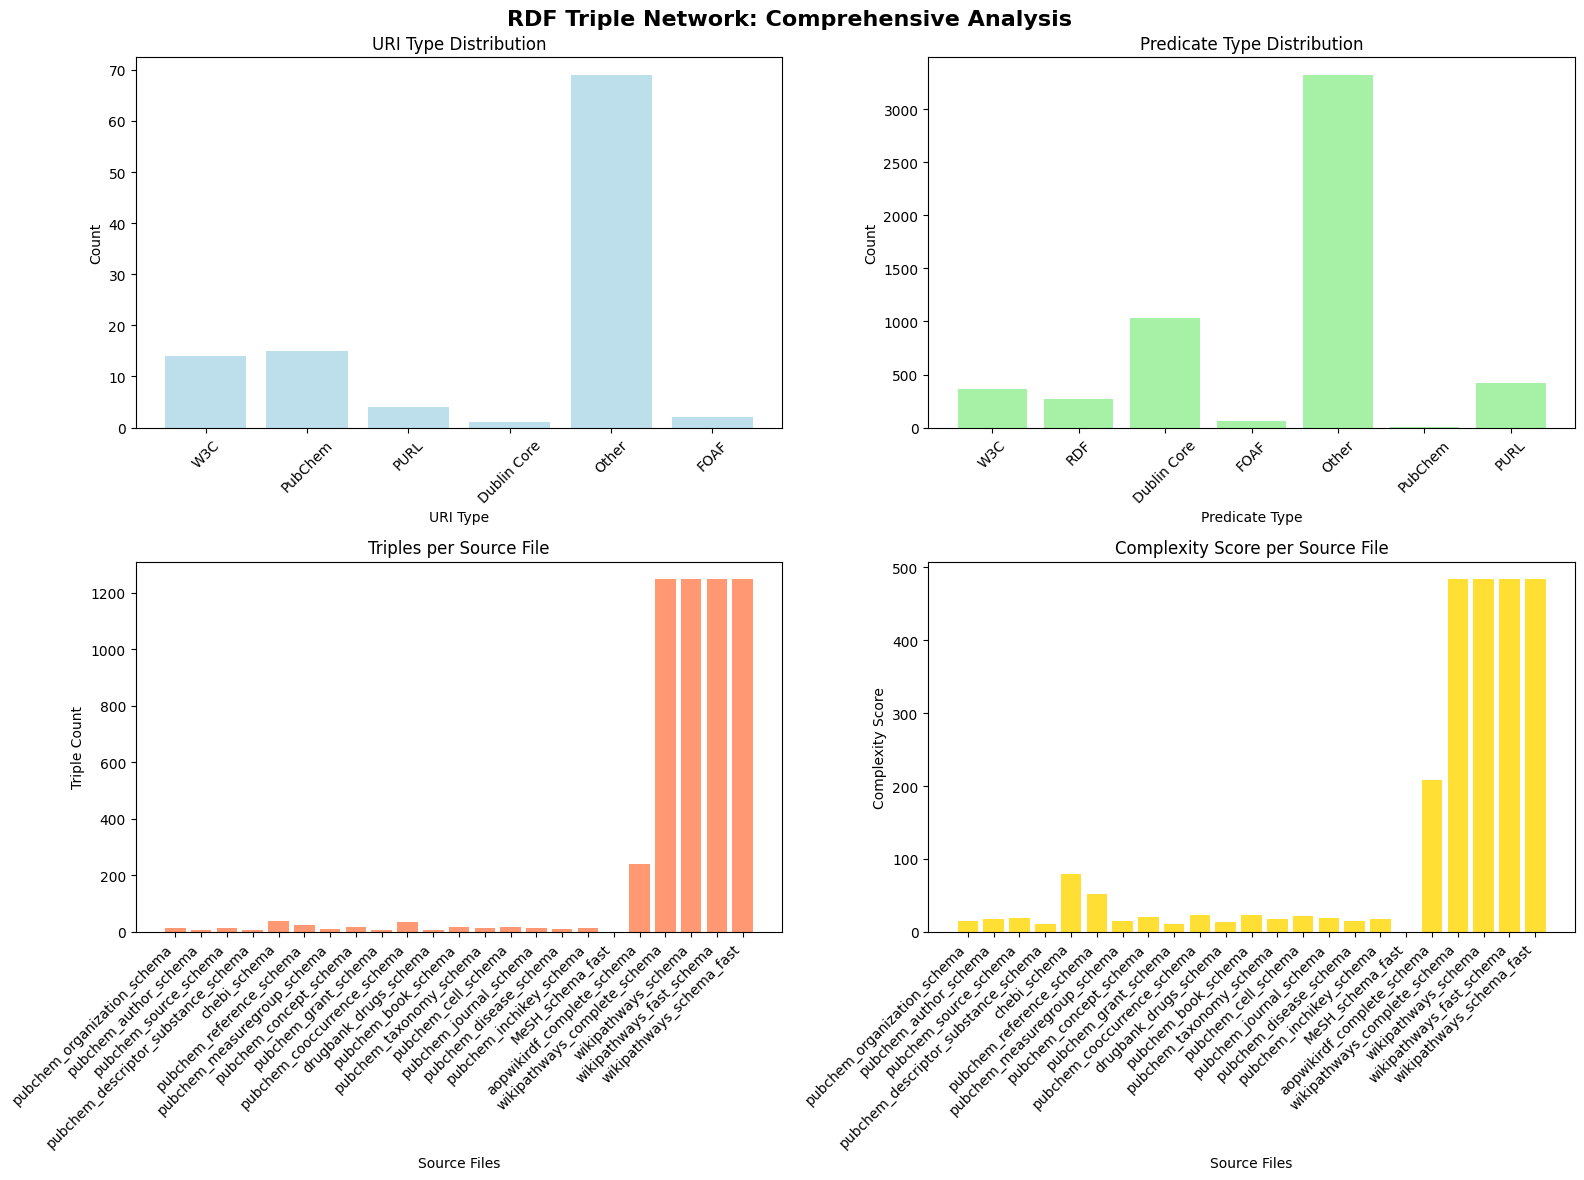


Key Insights and Conclusions:
1. Network contains 105 unique URIs from 5485 RDF triples
2. The network is fully connected, indicating strong relationships between URIs
3. Most common URI type is Other with 69 instances
4. Most common predicate type is Other with 3325 uses
5. Average degree is 104.48, indicating dense connectivity
6. Network density is 0.064469, showing low interconnectedness

This RDF triple network analysis reveals the structural patterns and
relationships within your semantic data schemas, enabling better
understanding of the knowledge graph topology and interconnections.


In [ ]:
def comprehensive_network_summary(G: nx.DiGraph, source_stats: Dict, predicate_analysis: Dict) -> Dict:
    """
    Generate a comprehensive summary of the domain-specific triple network
    """
    summary = {}
    
    if G.number_of_nodes() == 0:
        return {
            'network_type': 'Domain-Specific RDF Triple Network',
            'status': 'No domain nodes after filtering',
            'total_nodes': 0,
            'total_triples': 0,
            'filtering_note': 'All nodes were filtered out as schema/ontology entities'
        }
    
    # Convert to simple graph for analysis
    simple_G = nx.DiGraph()
    for node in G.nodes():
        simple_G.add_node(node, **G.nodes[node])
    
    edge_counts = defaultdict(int)
    for source, target in G.edges():
        edge_counts[(source, target)] += 1
    
    for (source, target), count in edge_counts.items():
        simple_G.add_edge(source, target, weight=count)
    
    # Basic structure metrics
    summary['network_type'] = 'Domain-Specific RDF Triple Network'
    summary['total_domain_nodes'] = G.number_of_nodes()
    summary['total_domain_triples'] = G.number_of_edges()
    summary['unique_domain_edges'] = simple_G.number_of_edges()
    summary['density'] = nx.density(simple_G)
    summary['average_degree'] = np.mean([d for n, d in G.degree()]) if G.number_of_nodes() > 0 else 0
    
    # Filtering statistics
    total_triples_processed = sum(stats['triple_count'] for stats in source_stats.values())
    total_domain_triples = sum(stats['filtered_triple_count'] for stats in source_stats.values())
    summary['total_triples_processed'] = total_triples_processed
    summary['filtering_ratio'] = ((total_triples_processed - total_domain_triples) / total_triples_processed) * 100 if total_triples_processed > 0 else 0
    
    # Connectivity metrics
    G_undirected = simple_G.to_undirected()
    summary['is_connected'] = nx.is_connected(G_undirected)
    summary['number_of_components'] = nx.number_connected_components(G_undirected)
    
    if summary['is_connected']:
        summary['diameter'] = nx.diameter(G_undirected)
        summary['average_path_length'] = nx.average_shortest_path_length(G_undirected)
    else:
        summary['diameter'] = 'N/A'
        summary['average_path_length'] = 'N/A'
    
    # Source file metrics
    summary['total_source_files'] = len(source_stats)
    sources_with_domain_data = len([s for s in source_stats.values() if s['filtered_triple_count'] > 0])
    summary['sources_with_domain_data'] = sources_with_domain_data
    
    # URI type distribution (domain nodes only)
    if G.number_of_nodes() > 0:
        uri_type_counts = Counter()
        for node in G.nodes():
            uri_type_counts[G.nodes[node]['uri_type']] += 1
        summary['domain_uri_types'] = dict(uri_type_counts)
        summary['most_common_domain_type'] = uri_type_counts.most_common(1)[0] if uri_type_counts else ('None', 0)
    else:
        summary['domain_uri_types'] = {}
        summary['most_common_domain_type'] = ('None', 0)
    
    # Enhanced predicate analysis
    summary['total_unique_predicates'] = len(predicate_analysis)
    
    # Predicate type distribution
    predicate_type_counts = Counter()
    predicate_usage_by_type = Counter()
    for predicate, stats in predicate_analysis.items():
        pred_type = classify_uri(predicate)
        predicate_type_counts[pred_type] += 1
        predicate_usage_by_type[pred_type] += stats['usage_count']
    
    summary['predicate_types'] = dict(predicate_type_counts)
    summary['predicate_usage_by_type'] = dict(predicate_usage_by_type)
    
    # Top predicates
    sorted_predicates = sorted(predicate_analysis.items(), key=lambda x: x[1]['usage_count'], reverse=True)
    if sorted_predicates:
        top_pred = sorted_predicates[0]
        summary['most_used_predicate'] = (top_pred[0], top_pred[1]['usage_count'])
    else:
        summary['most_used_predicate'] = ('None', 0)
    
    # Predicate connectivity metrics
    connectivity_scores = []
    for predicate, stats in predicate_analysis.items():
        if stats['usage_count'] > 0:
            connectivity = (len(stats['unique_subjects']) * len(stats['unique_objects'])) / stats['usage_count']
            connectivity_scores.append(connectivity)
    
    summary['average_predicate_connectivity'] = np.mean(connectivity_scores) if connectivity_scores else 0
    summary['max_predicate_connectivity'] = max(connectivity_scores) if connectivity_scores else 0
    
    return summary

# Generate comprehensive summary
network_summary = comprehensive_network_summary(G, source_stats, predicate_analysis)

print("Comprehensive Domain-Specific RDF Network Summary:")
print("=" * 70)

if network_summary.get('status') == 'No domain nodes after filtering':
    print("WARNING: FILTERING RESULT: No domain-specific nodes found!")
    print("=" * 70)
    print("All RDF triples contained only schema/ontology entities.")
    print("This suggests the data is primarily ontological definitions rather than instance data.")
    print(f"Total triples processed: {network_summary['total_triples_processed']}")
    print("\nPredicate analysis is still available below...")
else:
    for key, value in network_summary.items():
        if isinstance(value, dict):
            print(f"{key.replace('_', ' ').title()}:")
            for subkey, subvalue in value.items():
                print(f"  {subkey}: {subvalue}")
        elif isinstance(value, tuple):
            print(f"{key.replace('_', ' ').title()}: {value[0]} ({value[1]} occurrences)")
        else:
            print(f"{key.replace('_', ' ').title()}: {value}")

# Create detailed analysis DataFrame
analysis_data = {
    'Metric': [],
    'Value': [],
    'Description': []
}

# Add metrics to DataFrame
if network_summary['total_domain_nodes'] > 0:
    metrics_info = [
        ('Domain Nodes', network_summary['total_domain_nodes'], 'URIs after schema filtering'),
        ('Domain Triples', network_summary['total_domain_triples'], 'Triples between domain entities'),
        ('Filtering Efficiency', f"{network_summary['filtering_ratio']:.1f}%", 'Percentage of schema triples removed'),
        ('Unique Predicates', network_summary['total_unique_predicates'], 'All predicates found (including schema)'),
        ('Average Degree', f"{network_summary['average_degree']:.2f}", 'Average connections per domain node'),
        ('Connectivity', 'Yes' if network_summary['is_connected'] else 'No', 'Domain graph connectivity'),
        ('Components', network_summary['number_of_components'], 'Disconnected components'),
        ('Sources with Domain Data', f"{network_summary['sources_with_domain_data']}/{network_summary['total_source_files']}", 'Files containing domain entities')
    ]
else:
    metrics_info = [
        ('Total Triples Processed', network_summary['total_triples_processed'], 'All triples from source files'),
        ('Domain Nodes Found', 0, 'URIs after schema filtering'),
        ('Filtering Result', '100% filtered', 'All triples were schema/ontology'),
        ('Unique Predicates', network_summary['total_unique_predicates'], 'All predicates found (analysis available)'),
        ('Status', 'Schema-only dataset', 'Contains only ontological definitions')
    ]

for metric, value, desc in metrics_info:
    analysis_data['Metric'].append(metric)
    analysis_data['Value'].append(value)
    analysis_data['Description'].append(desc)

analysis_df = pd.DataFrame(analysis_data)

print(f"\nNetwork Analysis Summary:")
print("=" * 70)
print(analysis_df.to_string(index=False))

# Enhanced visualizations
if network_summary['total_domain_nodes'] > 0:
    # Create domain-specific visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Domain-Specific RDF Network: Comprehensive Analysis', fontsize=16, fontweight='bold')
    
    # Domain URI type distribution
    domain_types = network_summary['domain_uri_types']
    if domain_types:
        axes[0, 0].bar(domain_types.keys(), domain_types.values(), alpha=0.8, color='lightblue')
        axes[0, 0].set_title('Domain URI Types')
        axes[0, 0].tick_params(axis='x', rotation=45)
    else:
        axes[0, 0].text(0.5, 0.5, 'No Domain\nNodes', ha='center', va='center', transform=axes[0, 0].transAxes)
        axes[0, 0].set_title('Domain URI Types')
    
    # Predicate type distribution by usage
    pred_usage_by_type = network_summary['predicate_usage_by_type']
    axes[0, 1].bar(pred_usage_by_type.keys(), pred_usage_by_type.values(), alpha=0.8, color='lightgreen')
    axes[0, 1].set_title('Predicate Usage by Type')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Filtering efficiency
    source_names = list(source_stats.keys())
    filtering_ratios = []
    for stats in source_stats.values():
        if stats['triple_count'] > 0:
            ratio = ((stats['triple_count'] - stats['filtered_triple_count']) / stats['triple_count']) * 100
            filtering_ratios.append(ratio)
        else:
            filtering_ratios.append(0)
    
    short_names = [name.split('/')[-1].replace('.json', '') for name in source_names]
    axes[0, 2].bar(range(len(source_names)), filtering_ratios, alpha=0.8, color='coral')
    axes[0, 2].set_title('Filtering Ratio by Source (%)')
    axes[0, 2].set_xticks(range(len(source_names)))
    axes[0, 2].set_xticklabels(short_names, rotation=45, ha='right')
    
    # Domain vs total triples
    domain_triples = [stats['filtered_triple_count'] for stats in source_stats.values()]
    total_triples = [stats['triple_count'] for stats in source_stats.values()]
    
    x = np.arange(len(source_names))
    width = 0.35
    axes[1, 0].bar(x - width/2, total_triples, width, label='Total Triples', alpha=0.8, color='lightcoral')
    axes[1, 0].bar(x + width/2, domain_triples, width, label='Domain Triples', alpha=0.8, color='lightblue')
    axes[1, 0].set_title('Triples: Total vs Domain')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(short_names, rotation=45, ha='right')
    axes[1, 0].legend()
    
    # Predicate connectivity histogram
    connectivity_scores = []
    for predicate, stats in predicate_analysis.items():
        if stats['usage_count'] > 0:
            connectivity = (len(stats['unique_subjects']) * len(stats['unique_objects'])) / stats['usage_count']
            connectivity_scores.append(connectivity)
    
    if connectivity_scores:
        axes[1, 1].hist(connectivity_scores, bins=30, alpha=0.7, color='gold')
        axes[1, 1].set_title('Predicate Connectivity Distribution')
        axes[1, 1].set_xlabel('Connectivity Score')
        axes[1, 1].set_ylabel('Frequency')
    
    # Top predicates pie chart
    top_10_preds = sorted(predicate_analysis.items(), key=lambda x: x[1]['usage_count'], reverse=True)[:10]
    if top_10_preds:
        pred_names = [p[0].split('/')[-1] if '/' in p[0] else p[0].split('#')[-1] if '#' in p[0] else p[0][-15:] for p in top_10_preds]
        pred_counts = [p[1]['usage_count'] for p in top_10_preds]
        axes[1, 2].pie(pred_counts, labels=pred_names, autopct='%1.1f%%')
        axes[1, 2].set_title('Top 10 Predicates by Usage')
    
    plt.tight_layout()
    plt.show()

else:
    # Predicate-only analysis visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Schema-Only Dataset: Predicate Analysis', fontsize=16, fontweight='bold')
    
    # Predicate type counts
    pred_types = network_summary['predicate_types']
    axes[0, 0].bar(pred_types.keys(), pred_types.values(), alpha=0.8, color='lightcoral')
    axes[0, 0].set_title('Predicate Types (Count)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Predicate usage by type
    pred_usage = network_summary['predicate_usage_by_type']
    axes[0, 1].bar(pred_usage.keys(), pred_usage.values(), alpha=0.8, color='lightgreen')
    axes[0, 1].set_title('Predicate Usage by Type')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Source file processing
    source_names = list(source_stats.keys())
    triple_counts = [stats['triple_count'] for stats in source_stats.values()]
    short_names = [name.split('/')[-1].replace('.json', '') for name in source_names]
    
    axes[1, 0].bar(range(len(source_names)), triple_counts, alpha=0.8, color='skyblue')
    axes[1, 0].set_title('Triples per Source File')
    axes[1, 0].set_xticks(range(len(source_names)))
    axes[1, 0].set_xticklabels(short_names, rotation=45, ha='right')
    
    # Top predicates
    top_preds = sorted(predicate_analysis.items(), key=lambda x: x[1]['usage_count'], reverse=True)[:10]
    if top_preds:
        pred_names = [p[0].split('/')[-1] if '/' in p[0] else p[0].split('#')[-1] if '#' in p[0] else p[0][-20:] for p in top_preds]
        pred_counts = [p[1]['usage_count'] for p in top_preds]
        axes[1, 1].barh(range(len(pred_names)), pred_counts, alpha=0.8, color='gold')
        axes[1, 1].set_title('Top 10 Predicates')
        axes[1, 1].set_yticks(range(len(pred_names)))
        axes[1, 1].set_yticklabels(pred_names)
    
    plt.tight_layout()
    plt.show()

# Final insights
print(f"\nKey Insights and Conclusions:")
print("=" * 70)

insights = []

if network_summary['total_domain_nodes'] > 0:
    insights.append(f"Found {network_summary['total_domain_nodes']} domain entities after filtering {network_summary['filtering_ratio']:.1f}% schema nodes")
    insights.append(f"Domain network has {network_summary['total_domain_triples']} relationships between entities")
    
    if network_summary['is_connected']:
        insights.append("Domain entities form a connected network")
    else:
        insights.append(f"Domain entities split into {network_summary['number_of_components']} disconnected groups")
    
    most_common_domain = network_summary['most_common_domain_type']
    insights.append(f"Most common domain entity type: {most_common_domain[0]} ({most_common_domain[1]} entities)")
else:
    insights.append("Dataset contains only schema/ontology definitions - no domain instances found")
    insights.append("This is typical for ontology files, vocabulary definitions, or schema specifications")

insights.append(f"Total of {network_summary['total_unique_predicates']} unique predicates define the semantic relationships")

most_used_pred = network_summary['most_used_predicate']
pred_short = most_used_pred[0].split('/')[-1] if '/' in most_used_pred[0] else most_used_pred[0].split('#')[-1] if '#' in most_used_pred[0] else most_used_pred[0][-30:]
insights.append(f"Most used predicate: {pred_short} ({most_used_pred[1]} uses)")

if network_summary.get('average_predicate_connectivity', 0) > 0:
    insights.append(f"Average predicate connectivity: {network_summary['average_predicate_connectivity']:.2f}")

for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")

print(f"\nThis analysis reveals the semantic structure of your RDF data,")
print(f"distinguishing between schema definitions and actual domain knowledge.")
print(f"The predicate analysis shows how concepts are interconnected in your knowledge graph.")